**This notebook has implementation of ELENA for solving the vehicle routing problem on Augerat-1995 dataset set P.**

---


**Structure:**

1. Imports
2. Data Loading
3. Parameter Initialization
4. Implementation
5. Visualizations


---

Imports

In [ ]:
import xml.etree.ElementTree as ET
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import time
from typing import List, Tuple
from multiprocessing import Pool, cpu_count
from functools import lru_cache
import math
import random
import glob
import os
import re

In [ ]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Data Loading

In [ ]:
!unzip '/content/drive/MyDrive/DNA-Insipred NNs/Input/augerat-1995-set-p.zip'

Archive:  /content/drive/MyDrive/DNA-Insipred NNs/Input/augerat-1995-set-p.zip
  inflating: readme.txt              
  inflating: P-n016-k08.xml          
  inflating: P-n019-k02.xml          
  inflating: P-n020-k02.xml          
  inflating: P-n021-k02.xml          
  inflating: P-n022-k02.xml          
  inflating: P-n022-k08.xml          
  inflating: P-n023-k08.xml          
  inflating: P-n040-k05.xml          
  inflating: P-n045-k05.xml          
  inflating: P-n050-k07.xml          
  inflating: P-n050-k08.xml          
  inflating: P-n050-k10.xml          
  inflating: P-n051-k10.xml          
  inflating: P-n055-k07.xml          
  inflating: P-n055-k08.xml          
  inflating: P-n055-k10.xml          
  inflating: P-n055-k15.xml          
  inflating: P-n060-k10.xml          
  inflating: P-n060-k15.xml          
  inflating: P-n065-k10.xml          
  inflating: P-n070-k10.xml          
  inflating: P-n076-k04.xml          
  inflating: P-n076-k05.xml          
  inflati

Distance Calculation

In [ ]:
# Calculate total distance for VRP routes
@lru_cache(maxsize=None)
def calculate_distance(routes):
    total_distance = 0
    for route in routes:
        if route:  # Check if route is not empty
            # Add distance from depot to first city
            total_distance += dist_matrix[0, route[0]]
            # Add distance between cities
            total_distance += sum(dist_matrix[route[i], route[i+1]] for i in range(len(route)-1))
            # Add distance from last city back to depot
            total_distance += dist_matrix[route[-1], 0]
    return total_distance

ELENA Implementation: population size of 300 and initial mutation rate of 0.5

In [ ]:
class CompressedLP:
    def __init__(self, city_index):
        self.city_index = city_index
        self.epigenetic_tags = {
            'mutation_resistance': np.random.random(),
            'crossover_affinity': np.random.random(),
            'stability_score': np.random.random()
        }

class CompressedLPVRP:
    def __init__(self, num_cities, num_vehicles, capacity, demands, subpop_id=0):
        self.neurons = [CompressedLP(i) for i in range(1, num_cities)]  # Exclude depot
        self.num_vehicles = num_vehicles
        self.capacity = capacity
        self.demands = demands
        self.subpop_id = subpop_id
        self.fitness_history = []
        np.random.shuffle(self.neurons)
        self.needs_improvement = True

    def split_into_routes(self, sequence):
        routes = []
        current_route = []
        current_load = 0

        for city in sequence:
            if current_load + self.demands[city] <= self.capacity:
                current_route.append(city)
                current_load += self.demands[city]
            else:
                if current_route:
                    routes.append(tuple(current_route))
                current_route = [city]
                current_load = self.demands[city]

        if current_route:
            routes.append(tuple(current_route))

        # If we have more routes than vehicles, combine some routes
        while len(routes) > self.num_vehicles:
            # Find two shortest routes to combine
            routes.sort(key=len)
            combined = routes[0] + routes[1]
            routes = [combined] + routes[2:]

        return tuple(routes)

    def get_routes(self):
        sequence = [n.city_index for n in self.neurons]
        return self.split_into_routes(sequence)

    def two_opt(self, routes):
        improved = True
        best_distance = calculate_distance(routes)
        initial_distance = best_distance

        while improved:
            improved = False
            for route_idx, route in enumerate(routes):
                route = list(route)
                for i in range(len(route) - 1):
                    for j in range(i + 1, len(route)):
                        new_route = route[:i] + route[i:j+1][::-1] + route[j+1:]
                        new_routes = list(routes)
                        new_routes[route_idx] = tuple(new_route)
                        new_distance = calculate_distance(tuple(new_routes))

                        if new_distance < best_distance:
                            routes = tuple(new_routes)
                            best_distance = new_distance
                            improved = True

        improvement = initial_distance - best_distance
        self.update_epigenetic_tags(improvement)
        self.needs_improvement = False
        return routes, best_distance

    def update_epigenetic_tags(self, improvement):
        for neuron in self.neurons:
            if improvement > 0:
                neuron.epigenetic_tags['stability_score'] = min(1.0, neuron.epigenetic_tags['stability_score'] + 0.1)
                neuron.epigenetic_tags['mutation_resistance'] = min(1.0, neuron.epigenetic_tags['mutation_resistance'] + 0.05)
            else:
                neuron.epigenetic_tags['stability_score'] = max(0.0, neuron.epigenetic_tags['stability_score'] - 0.1)
                neuron.epigenetic_tags['mutation_resistance'] = max(0.0, neuron.epigenetic_tags['mutation_resistance'] - 0.05)

    def fitness(self):
        routes = self.get_routes()
        distance = calculate_distance(routes)
        return 1 / distance, routes

    def mutate(self):
        self.needs_improvement = True
        mutation_type = np.random.choice(['swap', 'insert', 'reverse'])

        eligible_indices = [i for i, n in enumerate(self.neurons)
                          if n.epigenetic_tags['mutation_resistance'] < np.random.random()]

        if len(eligible_indices) < 2:
            return

        if mutation_type == 'swap':
            i, j = np.random.choice(eligible_indices, 2, replace=False)
            self.neurons[i], self.neurons[j] = self.neurons[j], self.neurons[i]
        elif mutation_type == 'insert':
            i, j = np.random.choice(eligible_indices, 2, replace=False)
            city = self.neurons.pop(i)
            self.neurons.insert(j, city)
        else:  # reverse
            i, j = sorted(np.random.choice(eligible_indices, 2, replace=False))
            self.neurons[i:j+1] = reversed(self.neurons[i:j+1])

def crossover(parent1, parent2):
    child = CompressedLPVRP(
        len(parent1.neurons) + 1,  # Add 1 for depot
        parent1.num_vehicles,
        parent1.capacity,
        parent1.demands,
    )

    crossover_points = [i for i, n in enumerate(parent1.neurons)
                       if n.epigenetic_tags['crossover_affinity'] > 0.5]

    if len(crossover_points) >= 2:
        start, end = sorted(np.random.choice(crossover_points, 2, replace=False))
    else:
        start, end = sorted(np.random.choice(len(parent1.neurons), 2, replace=False))

    segment = parent1.neurons[start:end]
    child_cities = set(n.city_index for n in segment)
    remaining = [n for n in parent2.neurons if n.city_index not in child_cities]

    child.neurons = remaining[:start] + segment + remaining[start:]
    child.needs_improvement = True
    return child

def horizontal_gene_transfer(subpopulations):
    for i, subpop1 in enumerate(subpopulations):
        for j, subpop2 in enumerate(subpopulations):
            if i != j:
                for ind1 in subpop1:
                    for ind2 in subpop2:
                        if np.random.random() < 0.1:
                            stable_segment = find_stable_segment(ind1)
                            if stable_segment:
                                transfer_segment(ind2, stable_segment)

def find_stable_segment(individual):
    stability_threshold = 0.7
    stable_positions = [i for i, n in enumerate(individual.neurons)
                       if n.epigenetic_tags['stability_score'] > stability_threshold]

    if len(stable_positions) < 2:
        return None

    start = stable_positions[0]
    length = 1
    for i in range(1, len(stable_positions)):
        if stable_positions[i] == stable_positions[i-1] + 1:
            length += 1
        else:
            break

    if length >= 2:
        return individual.neurons[start:start+length]
    return None

def transfer_segment(recipient, segment):
    segment_cities = set(n.city_index for n in segment)
    recipient.neurons = [n for n in recipient.neurons if n.city_index not in segment_cities]

    # Handle case where recipient.neurons is empty
    if len(recipient.neurons) == 0:
        recipient.neurons = list(segment)
    else:
        insert_pos = np.random.randint(0, len(recipient.neurons))
        recipient.neurons[insert_pos:insert_pos] = segment

def process_individual(network):
    if np.random.random() < 0.5:
        network.mutate()

    if network.needs_improvement:
        routes = network.get_routes()
        routes, _ = network.two_opt(routes)
        # Reconstruct neurons from routes
        sequence = [city for route in routes for city in route]
        network.neurons = [CompressedLP(city) for city in sequence]

    return network.fitness()[0], network

def evolve_population(pop_size, generations, early_stopping_generations, num_cities, num_vehicles, capacity, demands, num_subpops=3):
    subpopulations = [
        [CompressedLPVRP(num_cities, num_vehicles, capacity, demands, subpop_id=i)
         for _ in range(pop_size // num_subpops)]
        for i in range(num_subpops)
    ]

    best_fitness = 0
    best_fitness_count = 0

    with Pool(processes=cpu_count()) as pool:
        for gen in range(generations):
            for subpop in subpopulations:
                fitnesses_and_networks = pool.map(process_individual, subpop)
                sorted_population = sorted(fitnesses_and_networks, key=lambda x: x[0], reverse=True)
                subpop[:] = [network for _, network in sorted_population]

            if gen % 5 == 0:
                horizontal_gene_transfer(subpopulations)

            current_best_fitness = max(
                subpop[0].fitness()[0] for subpop in subpopulations
            )
            avg_fitness = np.mean([ind.fitness()[0] for subpop in subpopulations for ind in subpop])

            print(f"Generation {gen}: Best Fitness = {current_best_fitness:.4f}, Avg Fitness = {avg_fitness:.4f}")

            if current_best_fitness > best_fitness:
                best_fitness = current_best_fitness
                best_fitness_count = 0
            else:
                best_fitness_count += 1

            if best_fitness_count >= early_stopping_generations:
                print(f"Early stopping at generation {gen}")
                break

            for subpop in subpopulations:
                elite_size = len(subpop) // 10
                new_population = list(subpop[:elite_size])

                while len(new_population) < len(subpop):
                    if np.random.random() < 0.7:
                        tournament_size = 5
                        parent1 = max(np.random.choice(subpop, tournament_size),
                                    key=lambda x: x.fitness()[0])
                        parent2 = max(np.random.choice(subpop, tournament_size),
                                    key=lambda x: x.fitness()[0])
                        child = crossover(parent1, parent2)
                    else:
                        child = np.random.choice(subpop[:len(subpop)//2])

                    new_population.append(child)

                subpop[:] = new_population

    return max(
        (max(subpop, key=lambda x: x.fitness()[0]) for subpop in subpopulations),
        key=lambda x: x.fitness()[0]
    )

def run_evolutionary_algorithm(num_cities, num_vehicles, capacity, pop_size=500, generations=50, early_stopping_generations=5):
    global cities, dist_matrix, demands

    # Generate random cities (depot is at index 0)
    cities = np.random.rand(num_cities, 2)
    dist_matrix = squareform(pdist(cities))

    # Generate random demands for each city (excluding depot)
    demands = np.zeros(num_cities)
    demands[1:] = np.random.randint(1, 11, size=num_cities-1)

    print(f"\nRunning VRP Evolutionary Algorithm for {num_cities} cities and {num_vehicles} vehicles...")
    start_time = time.time()

    # Initialize and evolve population
    subpopulations = [
        [CompressedLPVRP(num_cities, num_vehicles, capacity, demands, subpop_id=i)
         for _ in range(pop_size // 3)]
        for i in range(3)
    ]

    best_fitness = 0
    best_fitness_count = 0

    with Pool(processes=cpu_count()) as pool:
        for gen in range(generations):
            for subpop in subpopulations:
                fitnesses_and_networks = pool.map(process_individual, subpop)
                sorted_population = sorted(fitnesses_and_networks, key=lambda x: x[0], reverse=True)
                subpop[:] = [network for _, network in sorted_population]

            if gen % 5 == 0:
                horizontal_gene_transfer(subpopulations)

            current_best_fitness = max(
                subpop[0].fitness()[0] for subpop in subpopulations
            )
            avg_fitness = np.mean([ind.fitness()[0] for subpop in subpopulations for ind in subpop])

            print(f"Generation {gen}: Best Fitness = {current_best_fitness:.4f}, Avg Fitness = {avg_fitness:.4f}")

            if current_best_fitness > best_fitness:
                best_fitness = current_best_fitness
                best_fitness_count = 0
            else:
                best_fitness_count += 1

            if best_fitness_count >= early_stopping_generations:
                print(f"Early stopping at generation {gen}")
                break

            for subpop in subpopulations:
                elite_size = len(subpop) // 10
                new_population = list(subpop[:elite_size])

                while len(new_population) < len(subpop):
                    if np.random.random() < 0.7:
                        tournament_size = 5
                        parent1 = max(np.random.choice(subpop, tournament_size),
                                    key=lambda x: x.fitness()[0])
                        parent2 = max(np.random.choice(subpop, tournament_size),
                                    key=lambda x: x.fitness()[0])
                        child = crossover(parent1, parent2)
                    else:
                        child = np.random.choice(subpop[:len(subpop)//2])

                    new_population.append(child)

                subpop[:] = new_population

    # Get the best solution from all subpopulations
    best_solution = max(
        (max(subpop, key=lambda x: x.fitness()[0]) for subpop in subpopulations),
        key=lambda x: x.fitness()[0]
    )

    fitness, routes = best_solution.fitness()
    distance = 1 / fitness

    end_time = time.time()
    execution_time = end_time - start_time

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.scatter(cities[0, 0], cities[0, 1], c='green', s=100, label='Depot')
    plt.scatter(cities[1:, 0], cities[1:, 1], c='red', s=50, label='Cities')

    colors = plt.cm.rainbow(np.linspace(0, 1, len(routes)))
    for route, color in zip(routes, colors):
        if len(route) > 0:  # Only plot if route is not empty
            # Plot from depot to first city
            plt.plot([cities[0, 0], cities[route[0], 0]],
                    [cities[0, 1], cities[route[0], 1]], c=color)

            # Plot between cities
            for i in range(len(route)-1):
                start = cities[route[i]]
                end = cities[route[i+1]]
                plt.plot([start[0], end[0]], [start[1], end[1]], c=color)

            # Plot from last city back to depot
            plt.plot([cities[route[-1], 0], cities[0, 0]],
                    [cities[route[-1], 1], cities[0, 1]], c=color)

    plt.title(f"VRP Solution - {num_cities} cities, {num_vehicles} vehicles\n" +
             f"Total Distance: {distance:.4f}, Time: {execution_time:.2f}s")
    plt.xlabel("X coordinate")
    plt.ylabel("Y coordinate")
    plt.legend()
    plt.show()

    return {
        "distance": distance,
        "time": execution_time,
        "routes": routes
    }


Solving P-n016-k08.xml
Number of cities: 16
Number of vehicles: 8
Vehicle capacity: 35.0
Generation 0: Best Fitness = 0.0019, Avg Fitness = 0.0019
Generation 1: Best Fitness = 0.0022, Avg Fitness = 0.0019
Generation 2: Best Fitness = 0.0023, Avg Fitness = 0.0020
Generation 3: Best Fitness = 0.0023, Avg Fitness = 0.0020
Generation 4: Best Fitness = 0.0023, Avg Fitness = 0.0020
Generation 5: Best Fitness = 0.0020, Avg Fitness = 0.0018
Generation 6: Best Fitness = 0.0022, Avg Fitness = 0.0019
Generation 7: Best Fitness = 0.0023, Avg Fitness = 0.0019
Generation 8: Best Fitness = 0.0023, Avg Fitness = 0.0020
Early stopping at generation 8



Best solution routes:
Route 1: [0, 8, 2, 0] (Distance: 65.52)
Route 2: [0, 4, 0] (Distance: 44.05)
Route 3: [0, 1, 0] (Distance: 27.78)
Route 4: [0, 6, 0] (Distance: 24.08)
Route 5: [0, 7, 14, 0] (Distance: 68.12)
Route 6: [0, 3, 10, 0] (Distance: 65.57)
Route 7: [0, 5, 9, 13, 0] (Distance: 72.87)
Route 8: [0, 12, 15, 11, 0] (Distance: 74.50)
Total distance: 442.50
Execution time: 2.95 seconds

Solving P-n019-k02.xml
Number of cities: 19
Number of vehicles: 2
Vehicle capacity: 160.0
Generation 0: Best Fitness = 0.0024, Avg Fitness = 0.0024
Generation 1: Best Fitness = 0.0046, Avg Fitness = 0.0034
Generation 2: Best Fitness = 0.0048, Avg Fitness = 0.0039
Generation 3: Best Fitness = 0.0047, Avg Fitness = 0.0040
Generation 4: Best Fitness = 0.0047, Avg Fitness = 0.0041
Generation 5: Best Fitness = 0.0024, Avg Fitness = 0.0024
Generation 6: Best Fitness = 0.0044, Avg Fitness = 0.0035
Generation 7: Best Fitness = 0.0044, Avg Fitness = 0.0038
Early stopping at generation 7


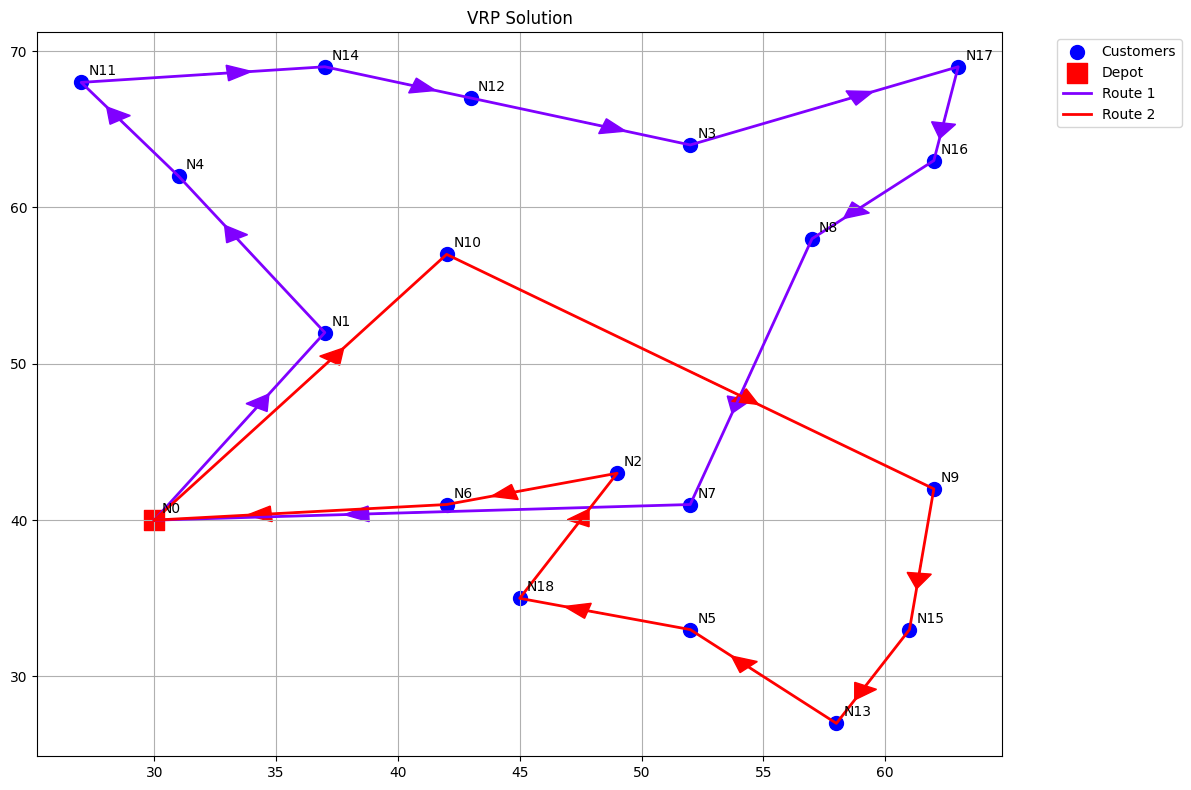


Best solution routes:
Route 1: [0, 1, 4, 11, 14, 12, 3, 17, 16, 8, 7, 0] (Distance: 123.61)
Route 2: [0, 10, 9, 15, 13, 5, 18, 2, 6, 0] (Distance: 105.60)
Total distance: 229.21
Execution time: 5.27 seconds

Solving P-n020-k02.xml
Number of cities: 20
Number of vehicles: 2
Vehicle capacity: 160.0
Generation 0: Best Fitness = 0.0025, Avg Fitness = 0.0022
Generation 1: Best Fitness = 0.0046, Avg Fitness = 0.0033
Generation 2: Best Fitness = 0.0046, Avg Fitness = 0.0038
Generation 3: Best Fitness = 0.0046, Avg Fitness = 0.0039
Generation 4: Best Fitness = 0.0046, Avg Fitness = 0.0040
Generation 5: Best Fitness = 0.0024, Avg Fitness = 0.0023
Generation 6: Best Fitness = 0.0046, Avg Fitness = 0.0034
Generation 7: Best Fitness = 0.0046, Avg Fitness = 0.0039
Early stopping at generation 7



Best solution routes:
Route 1: [0, 19, 5, 14, 16, 9, 7, 2, 10, 1, 0] (Distance: 97.53)
Route 2: [0, 4, 11, 15, 12, 3, 18, 17, 8, 13, 6, 0] (Distance: 119.89)
Total distance: 217.42
Execution time: 5.66 seconds

Solving P-n021-k02.xml
Number of cities: 21
Number of vehicles: 2
Vehicle capacity: 160.0
Generation 0: Best Fitness = 0.0026, Avg Fitness = 0.0022
Generation 1: Best Fitness = 0.0044, Avg Fitness = 0.0034
Generation 2: Best Fitness = 0.0045, Avg Fitness = 0.0038
Generation 3: Best Fitness = 0.0045, Avg Fitness = 0.0040
Generation 4: Best Fitness = 0.0045, Avg Fitness = 0.0041
Generation 5: Best Fitness = 0.0023, Avg Fitness = 0.0022
Generation 6: Best Fitness = 0.0043, Avg Fitness = 0.0034
Generation 7: Best Fitness = 0.0045, Avg Fitness = 0.0038
Generation 8: Best Fitness = 0.0047, Avg Fitness = 0.0040
Generation 9: Best Fitness = 0.0047, Avg Fitness = 0.0041
Generation 10: Best Fitness = 0.0024, Avg Fitness = 0.0023
Generation 11: Best Fitness = 0.0047, Avg Fitness = 0.0035



Best solution routes:
Route 1: [0, 4, 11, 15, 12, 3, 19, 18, 8, 10, 1, 16, 0] (Distance: 118.52)
Route 2: [0, 6, 7, 2, 13, 9, 17, 14, 5, 20, 0] (Distance: 94.19)
Total distance: 212.71
Execution time: 10.06 seconds

Solving P-n022-k02.xml
Number of cities: 22
Number of vehicles: 2
Vehicle capacity: 160.0
Generation 0: Best Fitness = 0.0023, Avg Fitness = 0.0022
Generation 1: Best Fitness = 0.0044, Avg Fitness = 0.0034
Generation 2: Best Fitness = 0.0045, Avg Fitness = 0.0038
Generation 3: Best Fitness = 0.0046, Avg Fitness = 0.0040
Generation 4: Best Fitness = 0.0046, Avg Fitness = 0.0040
Generation 5: Best Fitness = 0.0027, Avg Fitness = 0.0022
Generation 6: Best Fitness = 0.0046, Avg Fitness = 0.0034
Generation 7: Best Fitness = 0.0045, Avg Fitness = 0.0038
Generation 8: Best Fitness = 0.0046, Avg Fitness = 0.0039
Generation 9: Best Fitness = 0.0046, Avg Fitness = 0.0040
Early stopping at generation 9


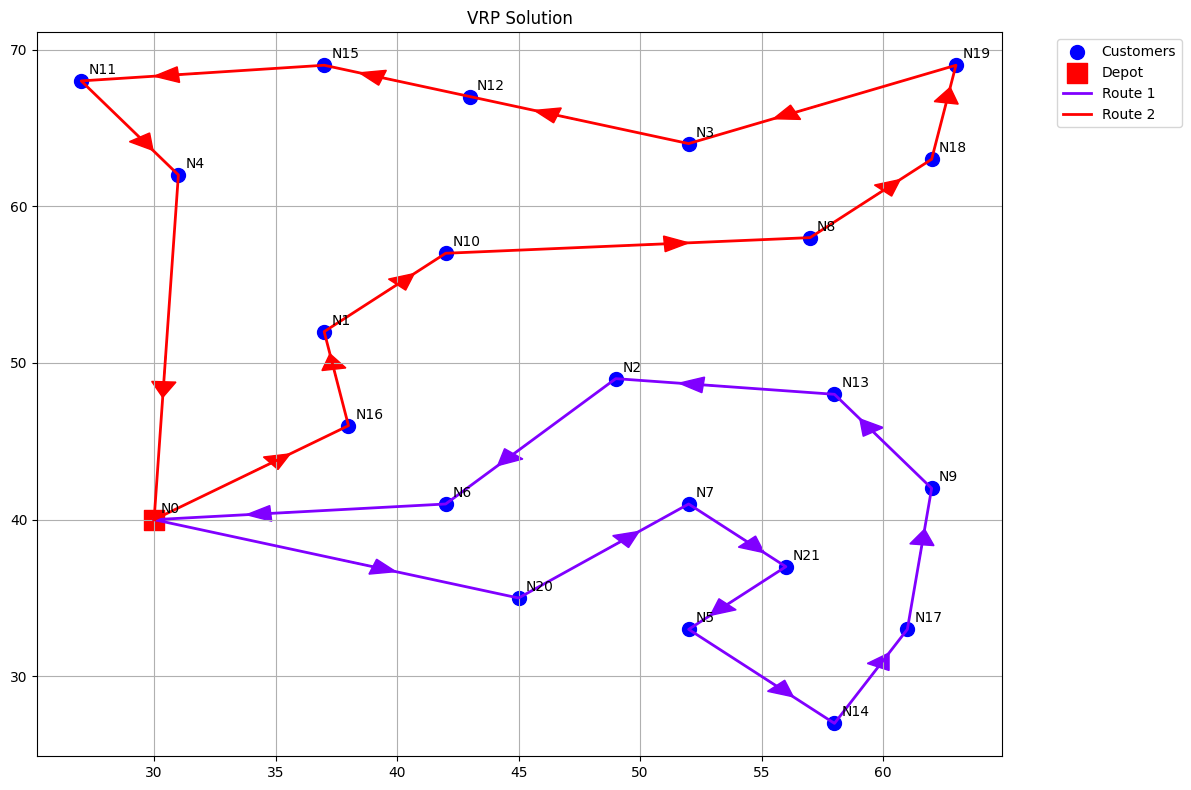


Best solution routes:
Route 1: [0, 20, 7, 21, 5, 14, 17, 9, 13, 2, 6, 0] (Distance: 99.53)
Route 2: [0, 16, 1, 10, 8, 18, 19, 3, 12, 15, 11, 4, 0] (Distance: 118.52)
Total distance: 218.05
Execution time: 7.84 seconds

Solving P-n022-k08.xml
Number of cities: 22
Number of vehicles: 8
Vehicle capacity: 3000.0
Generation 0: Best Fitness = 0.0011, Avg Fitness = 0.0011
Generation 1: Best Fitness = 0.0015, Avg Fitness = 0.0012
Generation 2: Best Fitness = 0.0015, Avg Fitness = 0.0012
Generation 3: Best Fitness = 0.0015, Avg Fitness = 0.0013
Generation 4: Best Fitness = 0.0015, Avg Fitness = 0.0013
Generation 5: Best Fitness = 0.0011, Avg Fitness = 0.0011
Generation 6: Best Fitness = 0.0015, Avg Fitness = 0.0012
Generation 7: Best Fitness = 0.0015, Avg Fitness = 0.0012
Generation 8: Best Fitness = 0.0015, Avg Fitness = 0.0013
Generation 9: Best Fitness = 0.0016, Avg Fitness = 0.0013
Generation 10: Best Fitness = 0.0012, Avg Fitness = 0.0011
Generation 11: Best Fitness = 0.0014, Avg Fitness 

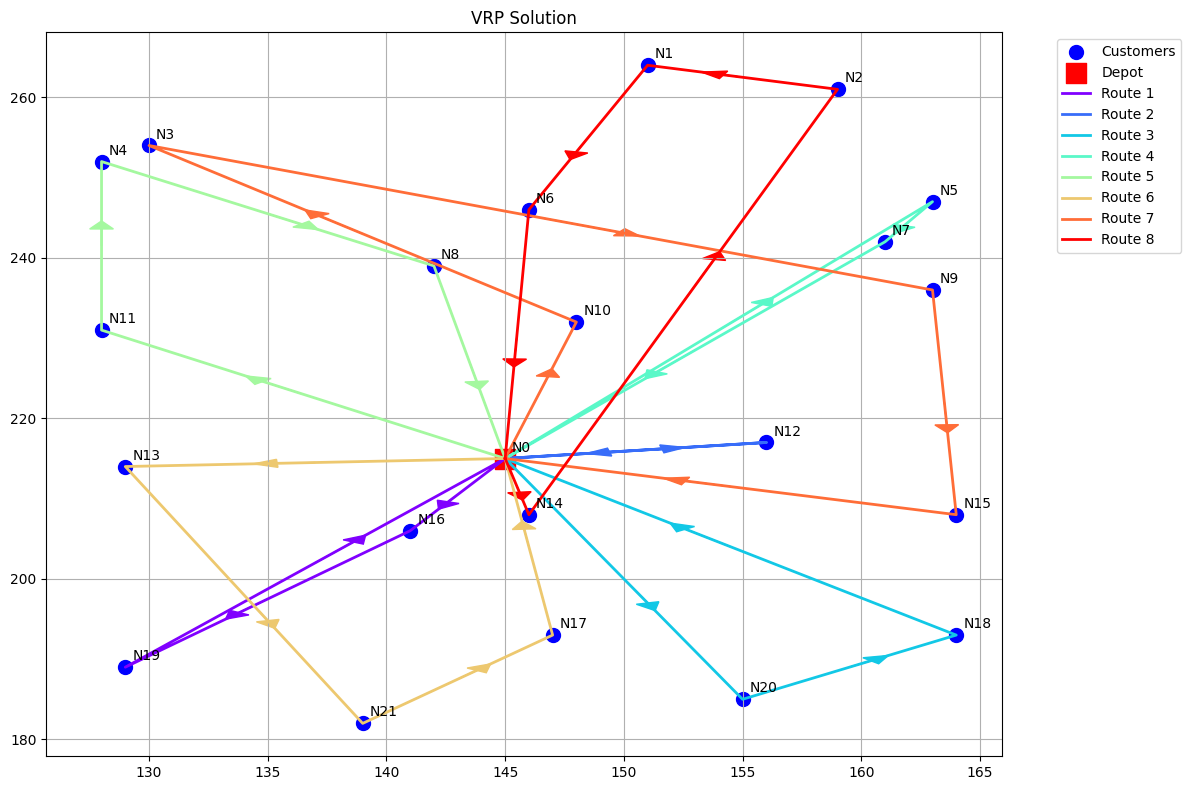


Best solution routes:
Route 1: [0, 16, 19, 0] (Distance: 61.19)
Route 2: [0, 12, 0] (Distance: 22.36)
Route 3: [0, 20, 18, 0] (Distance: 72.73)
Route 4: [0, 5, 7, 0] (Distance: 73.48)
Route 5: [0, 11, 4, 8, 0] (Distance: 87.64)
Route 6: [0, 13, 21, 17, 0] (Distance: 85.25)
Route 7: [0, 10, 3, 9, 15, 0] (Distance: 131.54)
Route 8: [0, 14, 2, 1, 6, 0] (Distance: 119.88)
Total distance: 654.08
Execution time: 6.14 seconds

Solving P-n023-k08.xml
Number of cities: 23
Number of vehicles: 8
Vehicle capacity: 40.0
Generation 0: Best Fitness = 0.0014, Avg Fitness = 0.0014
Generation 1: Best Fitness = 0.0017, Avg Fitness = 0.0015
Generation 2: Best Fitness = 0.0018, Avg Fitness = 0.0015
Generation 3: Best Fitness = 0.0018, Avg Fitness = 0.0015
Generation 4: Best Fitness = 0.0018, Avg Fitness = 0.0016
Generation 5: Best Fitness = 0.0015, Avg Fitness = 0.0014
Generation 6: Best Fitness = 0.0017, Avg Fitness = 0.0015
Generation 7: Best Fitness = 0.0018, Avg Fitness = 0.0015
Generation 8: Best Fit

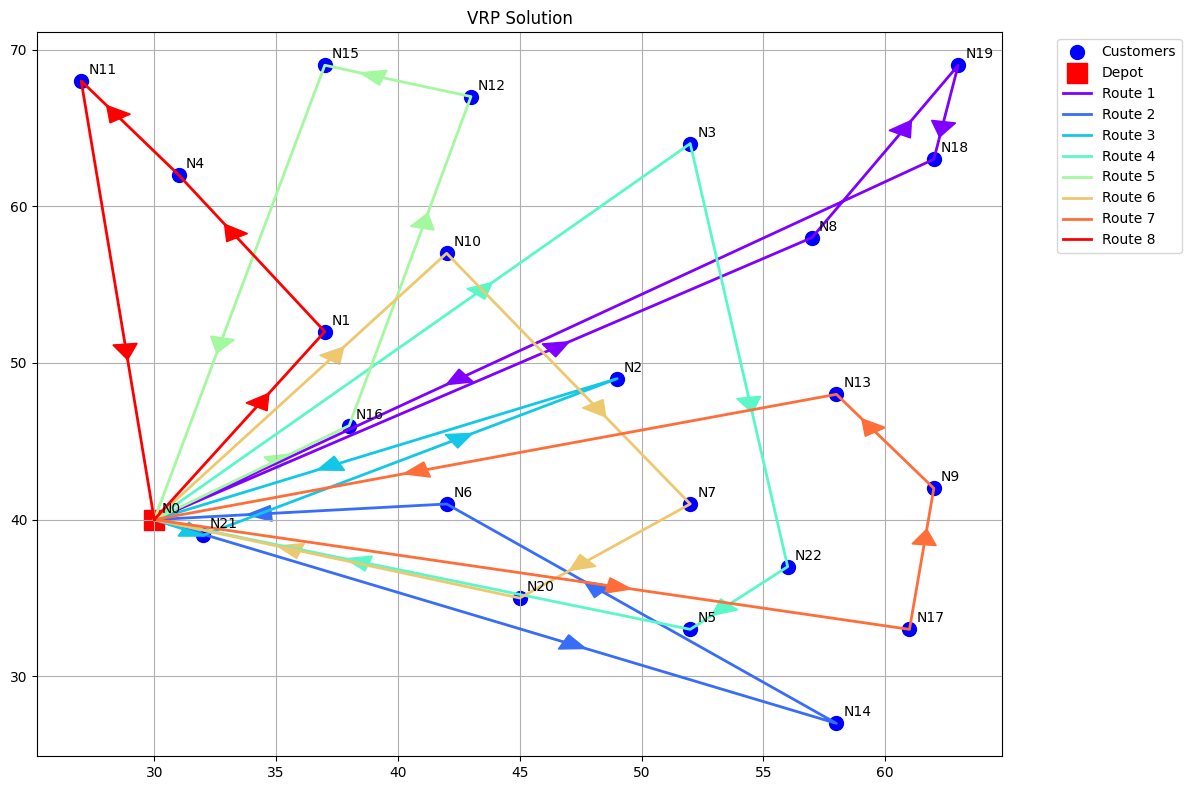


Best solution routes:
Route 1: [0, 8, 19, 18, 0] (Distance: 90.47)
Route 2: [0, 14, 6, 0] (Distance: 64.17)
Route 3: [0, 21, 2, 0] (Distance: 42.98)
Route 4: [0, 3, 22, 5, 0] (Distance: 88.60)
Route 5: [0, 16, 12, 15, 0] (Distance: 67.74)
Route 6: [0, 10, 7, 20, 0] (Distance: 64.71)
Route 7: [0, 17, 9, 13, 0] (Distance: 77.17)
Route 8: [0, 1, 4, 11, 0] (Distance: 60.93)
Total distance: 556.77
Execution time: 5.44 seconds

Solving P-n040-k05.xml
Number of cities: 40
Number of vehicles: 5
Vehicle capacity: 140.0
Generation 0: Best Fitness = 0.0008, Avg Fitness = 0.0008
Generation 1: Best Fitness = 0.0014, Avg Fitness = 0.0011
Generation 2: Best Fitness = 0.0015, Avg Fitness = 0.0013
Generation 3: Best Fitness = 0.0015, Avg Fitness = 0.0013
Generation 4: Best Fitness = 0.0016, Avg Fitness = 0.0014
Generation 5: Best Fitness = 0.0009, Avg Fitness = 0.0009
Generation 6: Best Fitness = 0.0015, Avg Fitness = 0.0012
Generation 7: Best Fitness = 0.0016, Avg Fitness = 0.0013
Generation 8: Best 

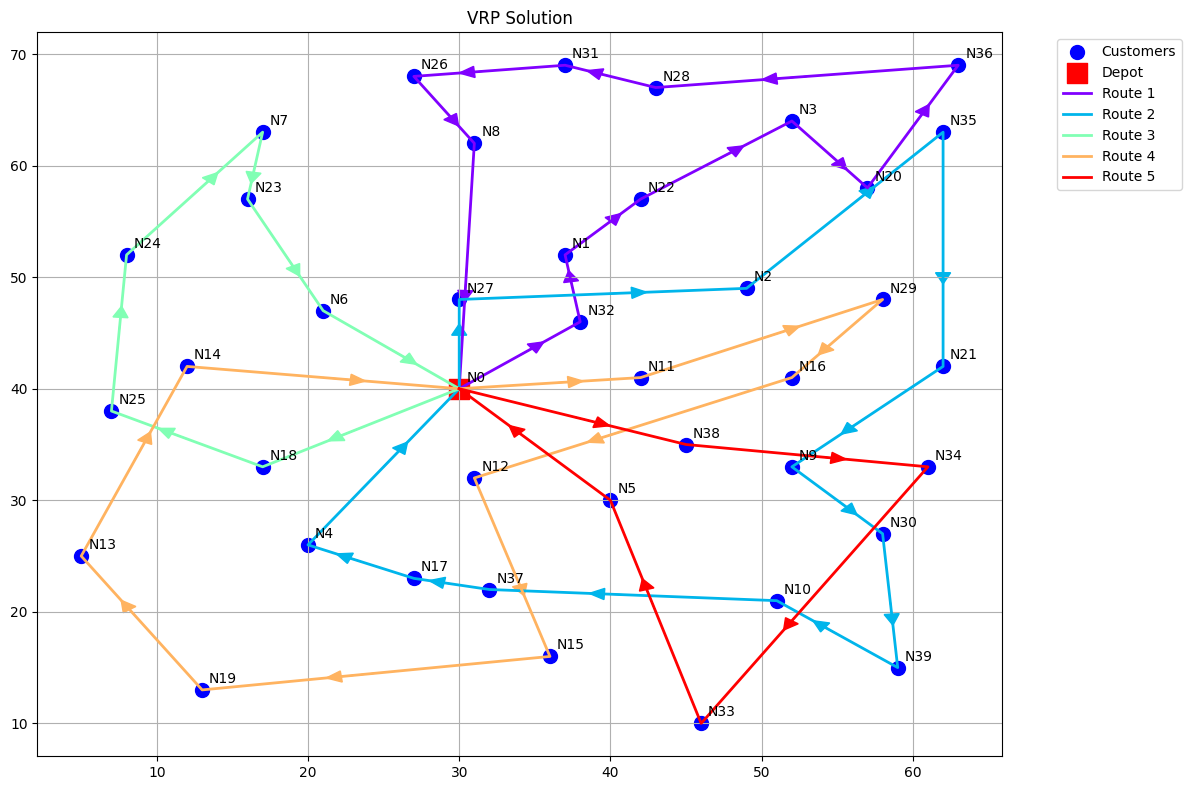


Best solution routes:
Route 1: [0, 32, 1, 22, 3, 20, 36, 28, 31, 26, 8, 0] (Distance: 121.41)
Route 2: [0, 27, 2, 35, 21, 9, 30, 39, 10, 37, 17, 4, 0] (Distance: 160.06)
Route 3: [0, 18, 25, 24, 7, 23, 6, 0] (Distance: 82.86)
Route 4: [0, 11, 29, 16, 12, 15, 19, 13, 14, 0] (Distance: 152.45)
Route 5: [0, 38, 34, 33, 5, 0] (Distance: 94.42)
Total distance: 611.19
Execution time: 22.47 seconds

Solving P-n045-k05.xml
Number of cities: 45
Number of vehicles: 5
Vehicle capacity: 150.0
Generation 0: Best Fitness = 0.0008, Avg Fitness = 0.0007
Generation 1: Best Fitness = 0.0013, Avg Fitness = 0.0010
Generation 2: Best Fitness = 0.0014, Avg Fitness = 0.0011
Generation 3: Best Fitness = 0.0015, Avg Fitness = 0.0012
Generation 4: Best Fitness = 0.0015, Avg Fitness = 0.0012
Generation 5: Best Fitness = 0.0008, Avg Fitness = 0.0007
Generation 6: Best Fitness = 0.0013, Avg Fitness = 0.0010
Generation 7: Best Fitness = 0.0015, Avg Fitness = 0.0012
Generation 8: Best Fitness = 0.0015, Avg Fitness 

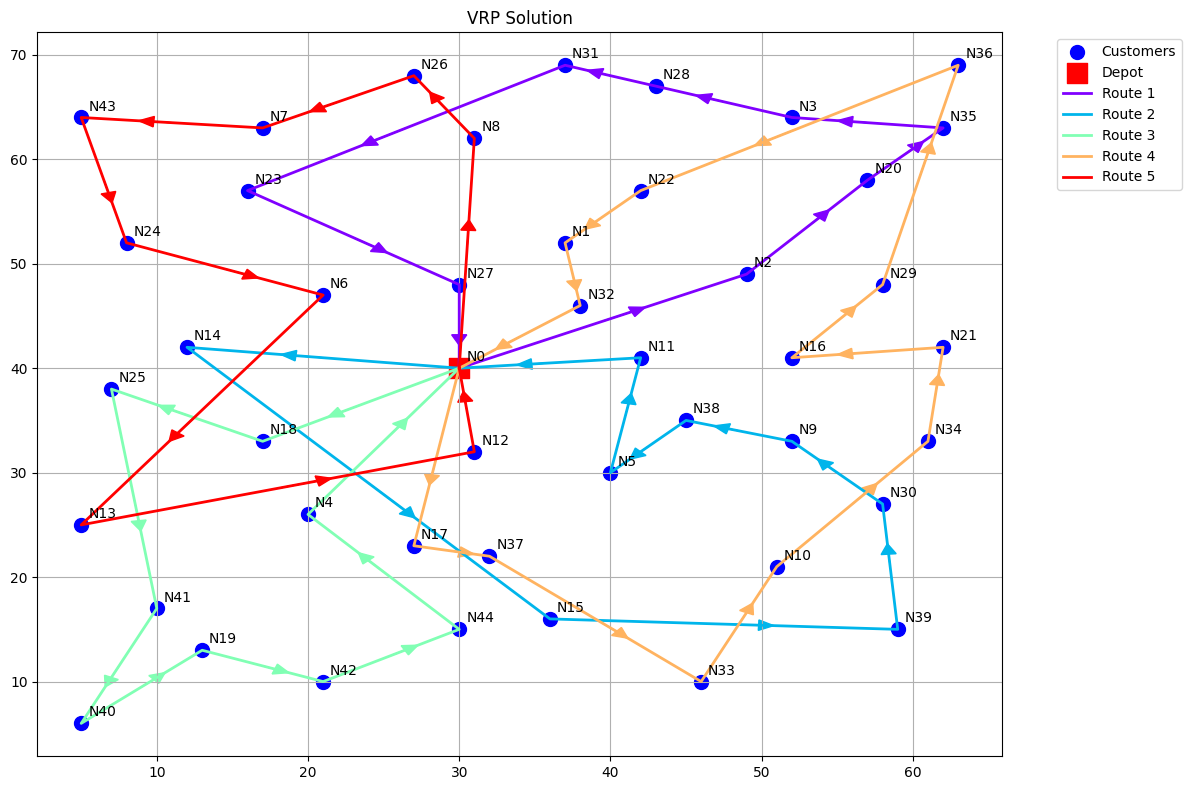


Best solution routes:
Route 1: [0, 2, 20, 35, 3, 28, 31, 23, 27, 0] (Distance: 114.83)
Route 2: [0, 14, 15, 39, 30, 9, 38, 5, 11, 0] (Distance: 134.62)
Route 3: [0, 18, 25, 41, 40, 19, 42, 44, 4, 0] (Distance: 120.78)
Route 4: [0, 17, 37, 33, 10, 34, 21, 16, 29, 36, 22, 1, 32, 0] (Distance: 165.76)
Route 5: [0, 8, 26, 7, 43, 24, 6, 13, 12, 0] (Distance: 140.94)
Total distance: 676.93
Execution time: 21.06 seconds

Solving P-n050-k07.xml
Number of cities: 50
Number of vehicles: 7
Vehicle capacity: 150.0
Generation 0: Best Fitness = 0.0008, Avg Fitness = 0.0007
Generation 1: Best Fitness = 0.0011, Avg Fitness = 0.0009
Generation 2: Best Fitness = 0.0012, Avg Fitness = 0.0010
Generation 3: Best Fitness = 0.0012, Avg Fitness = 0.0010
Generation 4: Best Fitness = 0.0012, Avg Fitness = 0.0011
Generation 5: Best Fitness = 0.0007, Avg Fitness = 0.0007
Generation 6: Best Fitness = 0.0011, Avg Fitness = 0.0009
Generation 7: Best Fitness = 0.0012, Avg Fitness = 0.0010
Early stopping at generatio

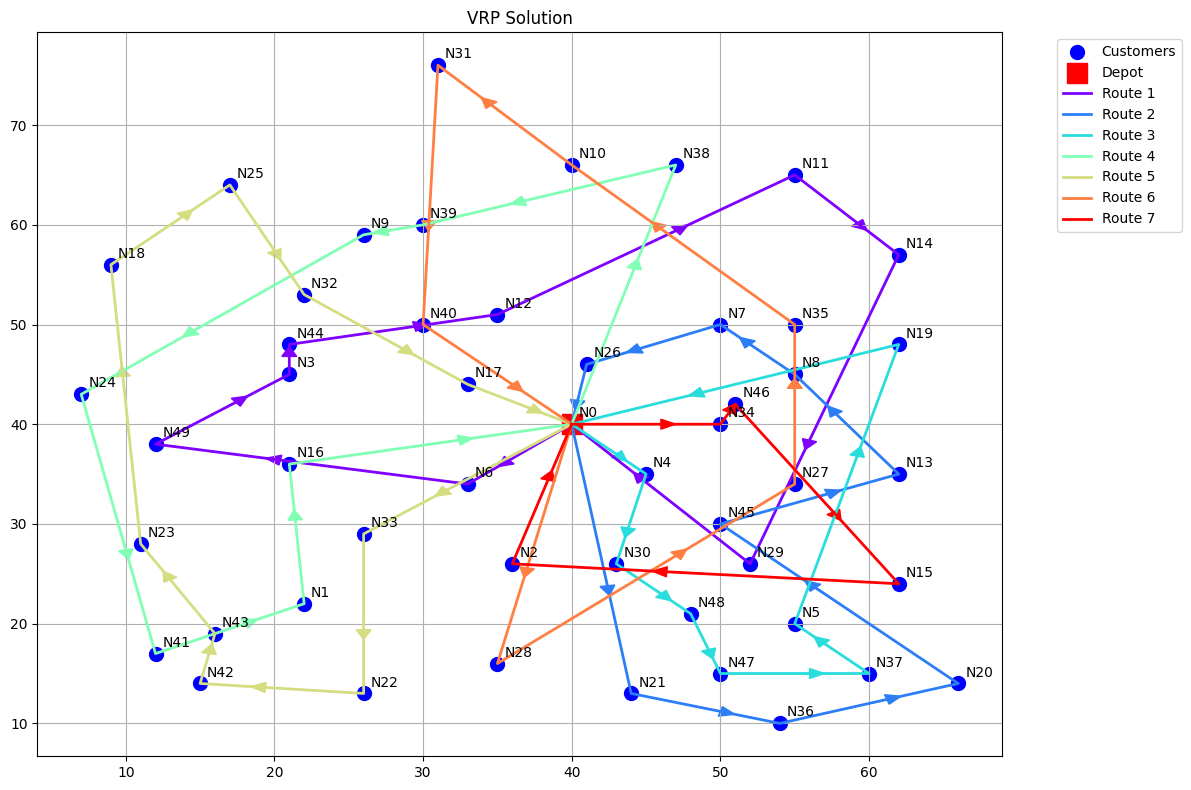


Best solution routes:
Route 1: [0, 6, 49, 3, 44, 12, 11, 14, 29, 0] (Distance: 145.37)
Route 2: [0, 21, 36, 20, 45, 13, 8, 7, 26, 0] (Distance: 121.22)
Route 3: [0, 4, 30, 48, 47, 37, 5, 19, 0] (Distance: 99.03)
Route 4: [0, 38, 39, 9, 24, 41, 1, 16, 0] (Distance: 145.03)
Route 5: [0, 33, 22, 42, 43, 23, 18, 25, 32, 17, 0] (Distance: 133.99)
Route 6: [0, 28, 27, 35, 10, 31, 40, 0] (Distance: 142.97)
Route 7: [0, 34, 46, 15, 2, 0] (Distance: 73.97)
Total distance: 861.57
Execution time: 15.11 seconds

Solving P-n050-k08.xml
Number of cities: 50
Number of vehicles: 8
Vehicle capacity: 120.0
Generation 0: Best Fitness = 0.0007, Avg Fitness = 0.0007
Generation 1: Best Fitness = 0.0010, Avg Fitness = 0.0008
Generation 2: Best Fitness = 0.0010, Avg Fitness = 0.0009
Generation 3: Best Fitness = 0.0011, Avg Fitness = 0.0009
Generation 4: Best Fitness = 0.0011, Avg Fitness = 0.0009
Generation 5: Best Fitness = 0.0008, Avg Fitness = 0.0007
Generation 6: Best Fitness = 0.0010, Avg Fitness = 0.00

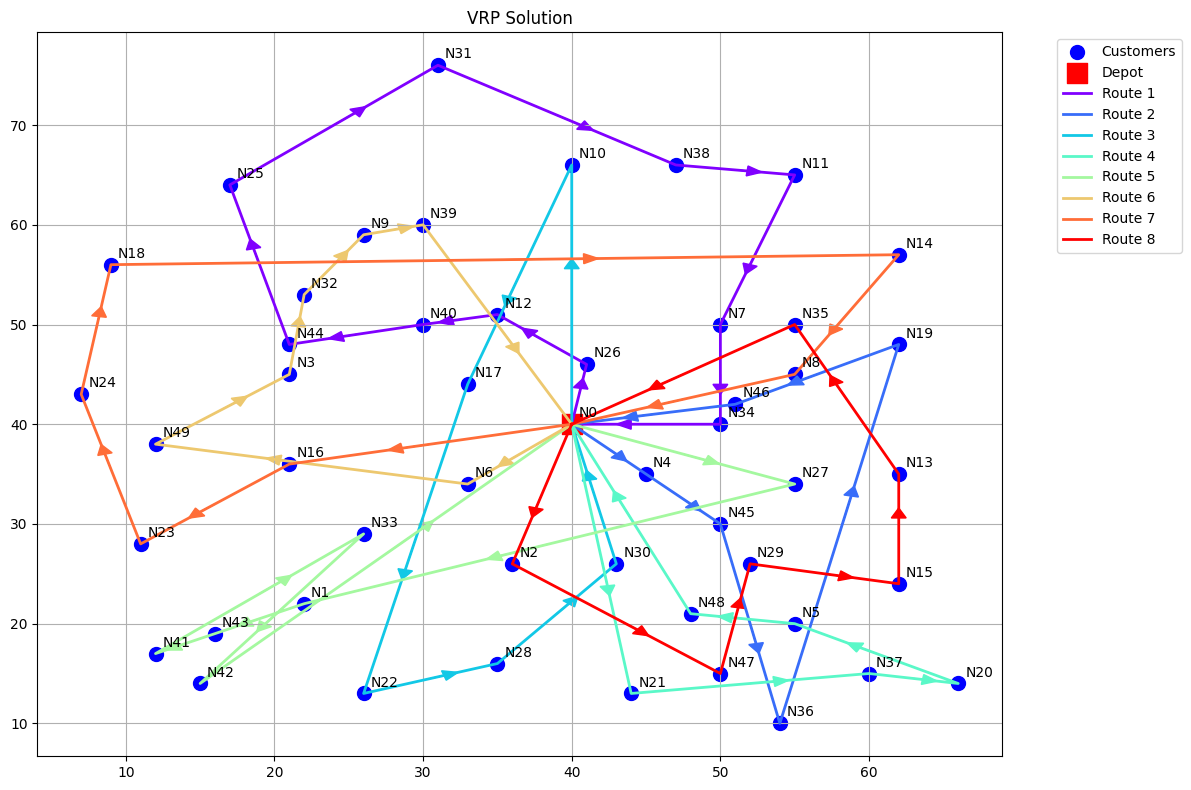


Best solution routes:
Route 1: [0, 26, 12, 40, 44, 25, 31, 38, 11, 7, 34, 0] (Distance: 125.88)
Route 2: [0, 4, 45, 36, 19, 46, 0] (Distance: 97.08)
Route 3: [0, 10, 17, 22, 28, 30, 0] (Distance: 117.48)
Route 4: [0, 21, 37, 20, 5, 48, 0] (Distance: 89.72)
Route 5: [0, 27, 1, 43, 41, 33, 42, 0] (Distance: 135.56)
Route 6: [0, 6, 49, 3, 32, 9, 39, 0] (Distance: 83.76)
Route 7: [0, 16, 23, 24, 18, 14, 8, 0] (Distance: 143.61)
Route 8: [0, 2, 47, 29, 15, 13, 35, 0] (Distance: 99.32)
Total distance: 892.42
Execution time: 31.79 seconds

Solving P-n050-k10.xml
Number of cities: 50
Number of vehicles: 10
Vehicle capacity: 100.0
Generation 0: Best Fitness = 0.0007, Avg Fitness = 0.0006
Generation 1: Best Fitness = 0.0009, Avg Fitness = 0.0007
Generation 2: Best Fitness = 0.0009, Avg Fitness = 0.0008
Generation 3: Best Fitness = 0.0009, Avg Fitness = 0.0008
Generation 4: Best Fitness = 0.0009, Avg Fitness = 0.0008
Generation 5: Best Fitness = 0.0007, Avg Fitness = 0.0006
Generation 6: Best Fi

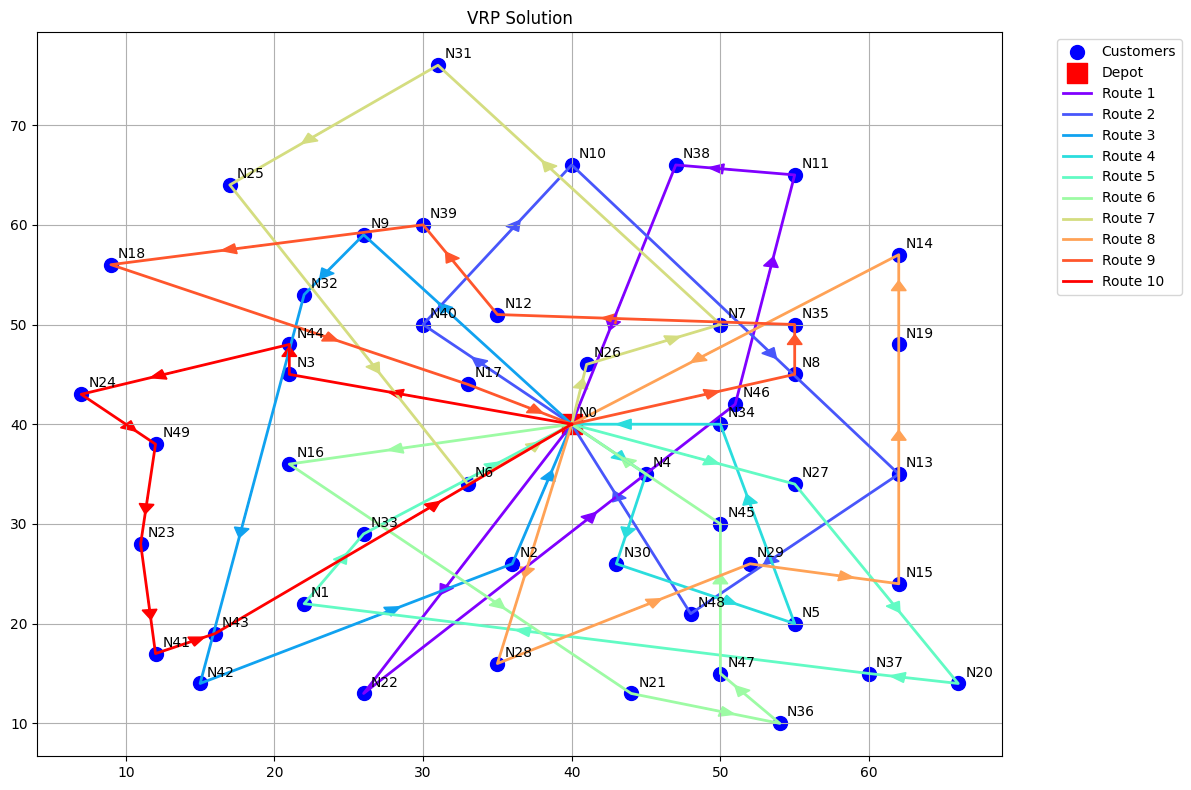


Best solution routes:
Route 1: [0, 22, 46, 11, 38, 0] (Distance: 127.04)
Route 2: [0, 40, 10, 13, 48, 0] (Distance: 111.44)
Route 3: [0, 9, 32, 42, 2, 0] (Distance: 109.18)
Route 4: [0, 4, 30, 5, 34, 0] (Distance: 60.32)
Route 5: [0, 27, 20, 37, 1, 33, 0] (Distance: 109.57)
Route 6: [0, 16, 21, 36, 47, 45, 0] (Distance: 97.93)
Route 7: [0, 26, 7, 31, 25, 6, 0] (Distance: 109.79)
Route 8: [0, 28, 29, 15, 19, 14, 0] (Distance: 115.24)
Route 9: [0, 8, 35, 12, 39, 18, 17, 0] (Distance: 107.40)
Route 10: [0, 3, 44, 24, 49, 23, 41, 43, 0] (Distance: 102.04)
Total distance: 1049.96
Execution time: 26.60 seconds

Solving P-n051-k10.xml
Number of cities: 51
Number of vehicles: 10
Vehicle capacity: 80.0
Generation 0: Best Fitness = 0.0007, Avg Fitness = 0.0006
Generation 1: Best Fitness = 0.0009, Avg Fitness = 0.0007
Generation 2: Best Fitness = 0.0009, Avg Fitness = 0.0007
Generation 3: Best Fitness = 0.0009, Avg Fitness = 0.0008
Generation 4: Best Fitness = 0.0009, Avg Fitness = 0.0008
Genera

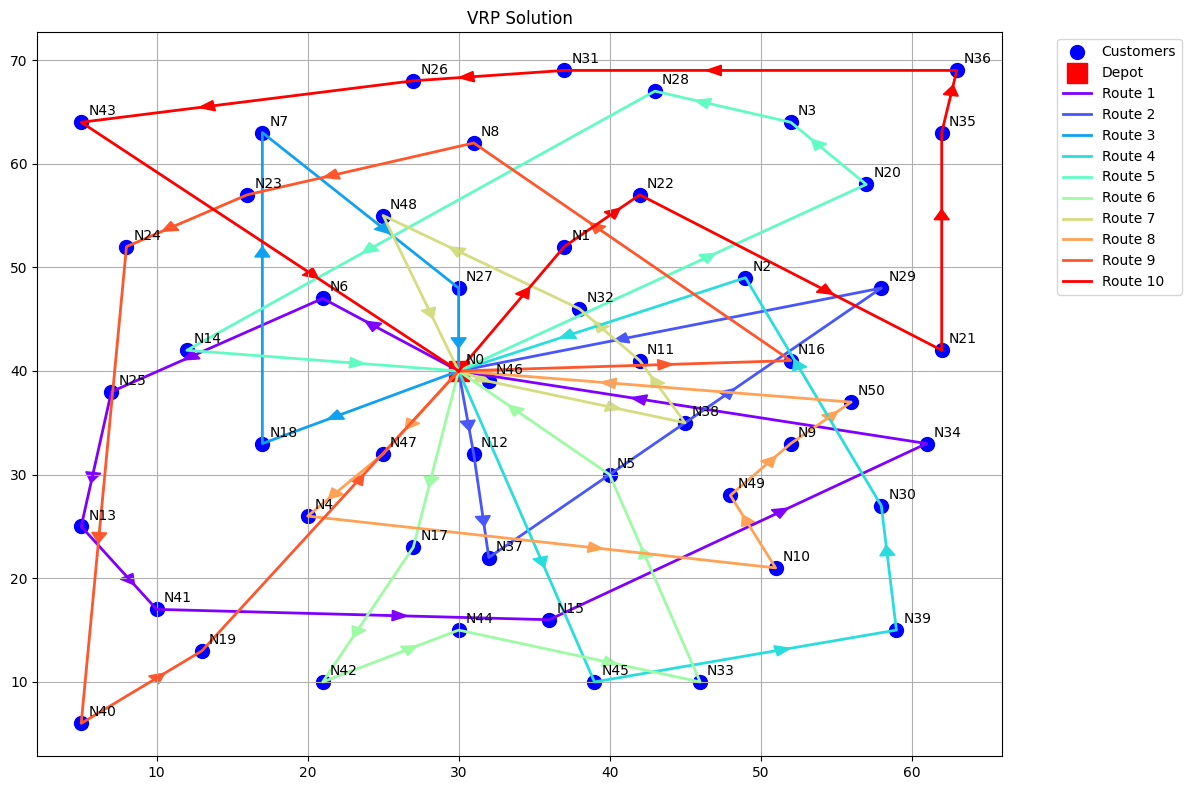


Best solution routes:
Route 1: [0, 6, 25, 13, 41, 15, 34, 0] (Distance: 138.66)
Route 2: [0, 12, 37, 29, 0] (Distance: 84.00)
Route 3: [0, 18, 7, 27, 0] (Distance: 72.61)
Route 4: [0, 45, 39, 30, 2, 0] (Distance: 108.77)
Route 5: [0, 20, 3, 28, 14, 0] (Distance: 107.68)
Route 6: [0, 17, 42, 44, 33, 5, 0] (Distance: 93.66)
Route 7: [0, 46, 38, 11, 32, 48, 0] (Distance: 60.57)
Route 8: [0, 47, 4, 10, 49, 9, 50, 0] (Distance: 94.49)
Route 9: [0, 16, 8, 23, 24, 40, 19, 0] (Distance: 165.60)
Route 10: [0, 1, 22, 21, 35, 36, 31, 26, 43, 0] (Distance: 166.11)
Total distance: 1092.17
Execution time: 21.44 seconds

Solving P-n055-k07.xml
Number of cities: 55
Number of vehicles: 7
Vehicle capacity: 170.0
Generation 0: Best Fitness = 0.0007, Avg Fitness = 0.0006
Generation 1: Best Fitness = 0.0010, Avg Fitness = 0.0009
Generation 2: Best Fitness = 0.0011, Avg Fitness = 0.0010
Generation 3: Best Fitness = 0.0012, Avg Fitness = 0.0010
Generation 4: Best Fitness = 0.0012, Avg Fitness = 0.0010
Gener

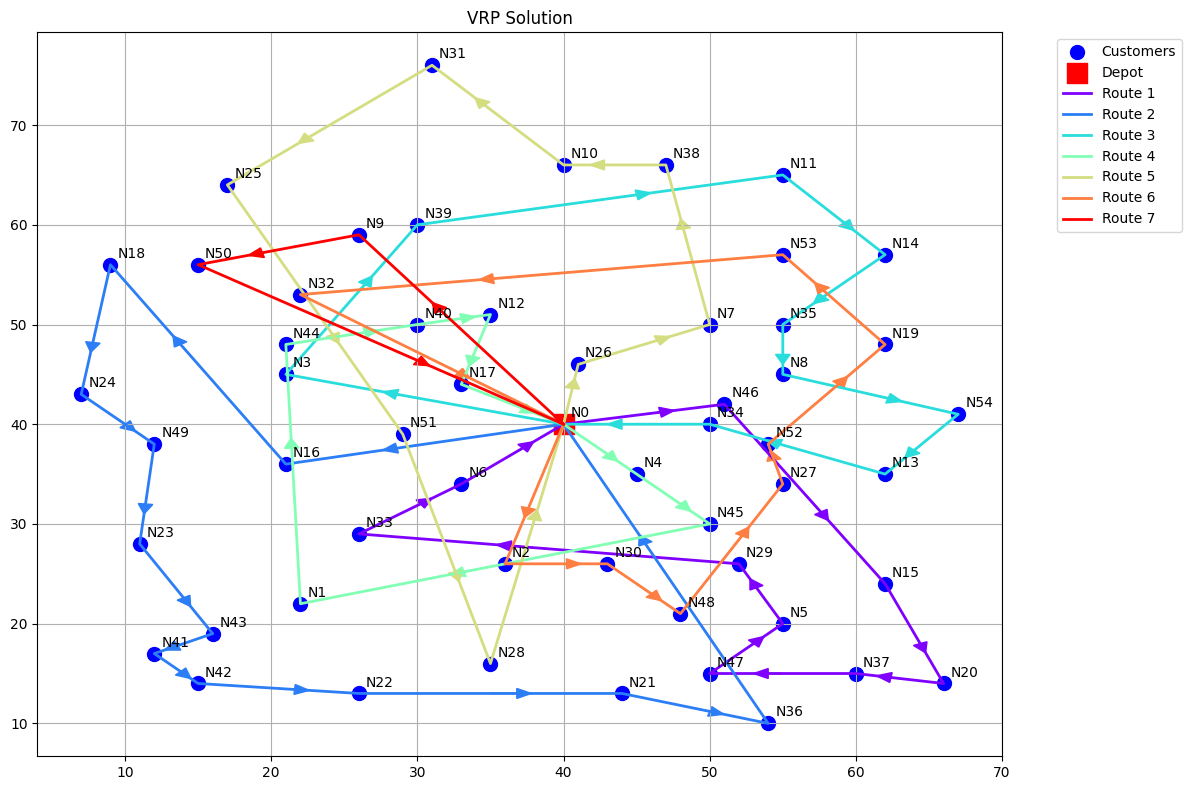


Best solution routes:
Route 1: [0, 46, 15, 20, 37, 47, 5, 29, 33, 6, 0] (Distance: 116.90)
Route 2: [0, 16, 18, 24, 49, 23, 43, 41, 42, 22, 21, 36, 0] (Distance: 164.62)
Route 3: [0, 3, 39, 11, 14, 35, 8, 54, 13, 34, 0] (Distance: 131.62)
Route 4: [0, 4, 45, 1, 44, 40, 12, 17, 0] (Distance: 98.94)
Route 5: [0, 26, 7, 38, 10, 31, 25, 51, 28, 0] (Distance: 147.12)
Route 6: [0, 2, 30, 48, 27, 52, 19, 53, 32, 0] (Distance: 127.17)
Route 7: [0, 9, 50, 0] (Distance: 64.68)
Total distance: 851.06
Execution time: 34.84 seconds

Solving P-n055-k08.xml
Number of cities: 55
Number of vehicles: 8
Vehicle capacity: 160.0
Generation 0: Best Fitness = 0.0007, Avg Fitness = 0.0006
Generation 1: Best Fitness = 0.0012, Avg Fitness = 0.0008
Generation 2: Best Fitness = 0.0012, Avg Fitness = 0.0009
Generation 3: Best Fitness = 0.0012, Avg Fitness = 0.0010
Generation 4: Best Fitness = 0.0012, Avg Fitness = 0.0010
Generation 5: Best Fitness = 0.0007, Avg Fitness = 0.0007
Generation 6: Best Fitness = 0.0011

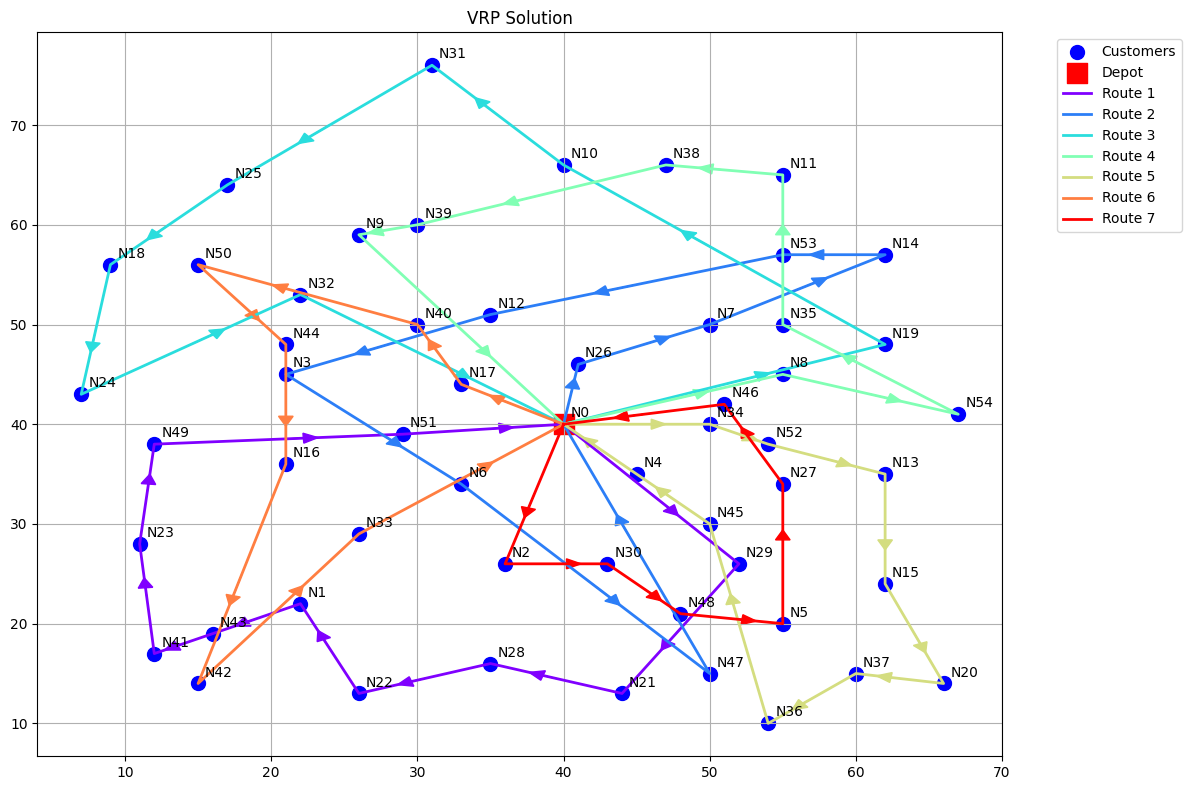


Best solution routes:
Route 1: [0, 29, 21, 28, 22, 1, 43, 41, 23, 49, 51, 0] (Distance: 122.88)
Route 2: [0, 26, 7, 14, 53, 12, 3, 6, 47, 0] (Distance: 141.64)
Route 3: [0, 19, 10, 31, 25, 18, 24, 32, 0] (Distance: 148.43)
Route 4: [0, 8, 54, 35, 11, 38, 39, 9, 0] (Distance: 112.27)
Route 5: [0, 34, 52, 13, 15, 20, 37, 36, 45, 4, 0] (Distance: 93.22)
Route 6: [0, 17, 40, 50, 44, 16, 42, 33, 0] (Distance: 112.14)
Route 7: [0, 2, 30, 48, 5, 27, 46, 0] (Distance: 69.83)
Total distance: 800.39
Execution time: 34.81 seconds

Solving P-n055-k10.xml
Number of cities: 55
Number of vehicles: 10
Vehicle capacity: 115.0
Generation 0: Best Fitness = 0.0006, Avg Fitness = 0.0006
Generation 1: Best Fitness = 0.0008, Avg Fitness = 0.0007
Generation 2: Best Fitness = 0.0009, Avg Fitness = 0.0008
Generation 3: Best Fitness = 0.0009, Avg Fitness = 0.0008
Generation 4: Best Fitness = 0.0010, Avg Fitness = 0.0008
Generation 5: Best Fitness = 0.0006, Avg Fitness = 0.0006
Generation 6: Best Fitness = 0.000

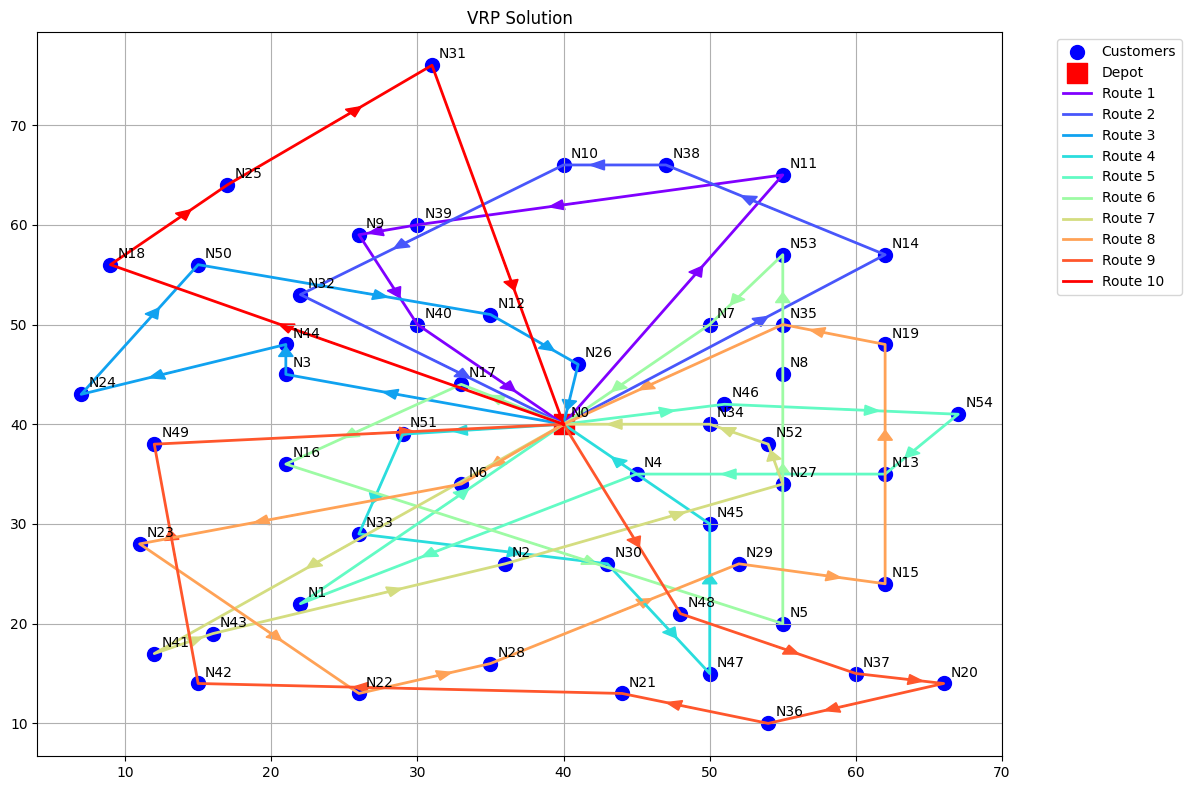


Best solution routes:
Route 1: [0, 11, 39, 9, 40, 0] (Distance: 82.76)
Route 2: [0, 14, 38, 10, 32, 0] (Distance: 96.70)
Route 3: [0, 3, 44, 24, 50, 12, 26, 0] (Distance: 87.29)
Route 4: [0, 51, 33, 30, 47, 45, 0] (Distance: 80.93)
Route 5: [0, 46, 54, 13, 4, 1, 0] (Distance: 103.90)
Route 6: [0, 17, 16, 5, 8, 53, 7, 0] (Distance: 119.81)
Route 7: [0, 41, 43, 2, 27, 52, 34, 0] (Distance: 101.11)
Route 8: [0, 6, 23, 22, 28, 29, 15, 19, 35, 0] (Distance: 141.95)
Route 9: [0, 48, 37, 20, 36, 21, 42, 49, 0] (Distance: 144.48)
Route 10: [0, 18, 25, 31, 0] (Distance: 101.75)
Total distance: 1060.67
Execution time: 16.62 seconds

Solving P-n055-k15.xml
Number of cities: 55
Number of vehicles: 15
Vehicle capacity: 70.0
Generation 0: Best Fitness = 0.0006, Avg Fitness = 0.0005
Generation 1: Best Fitness = 0.0007, Avg Fitness = 0.0006
Generation 2: Best Fitness = 0.0007, Avg Fitness = 0.0006
Generation 3: Best Fitness = 0.0007, Avg Fitness = 0.0006
Generation 4: Best Fitness = 0.0008, Avg Fitne

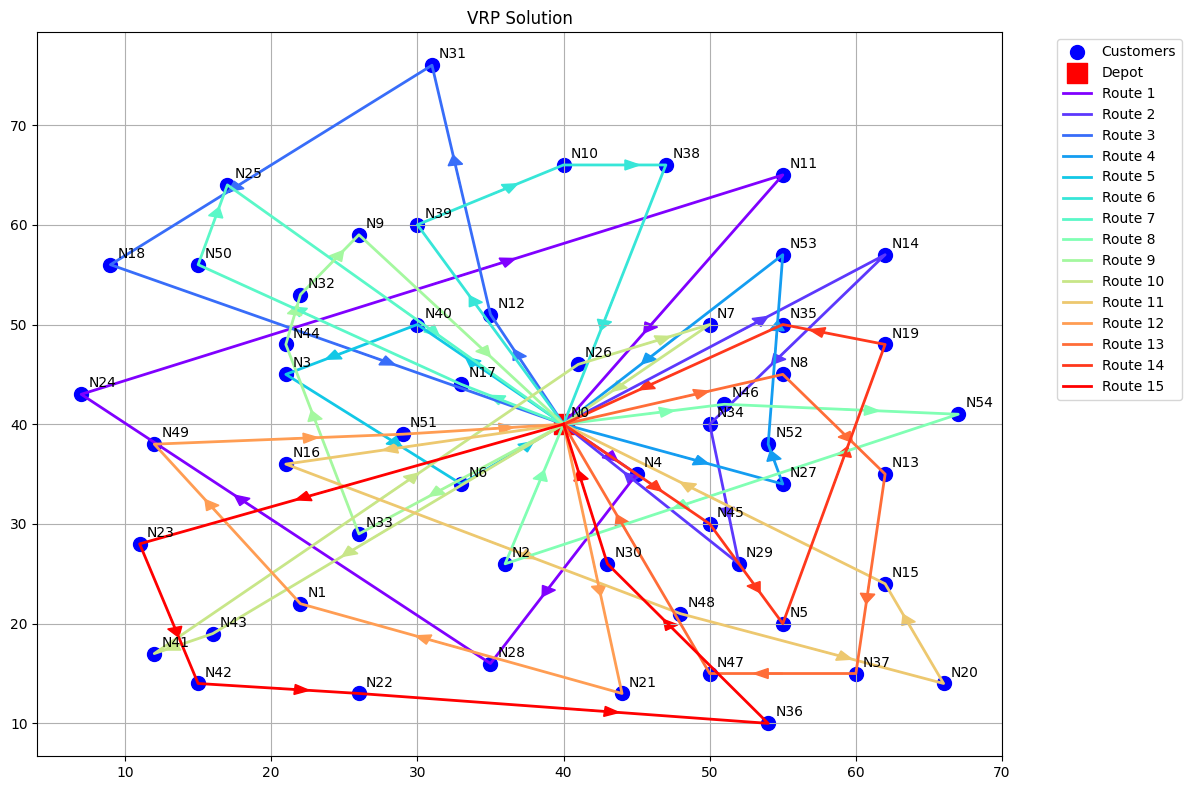


Best solution routes:
Route 1: [0, 4, 28, 24, 11, 0] (Distance: 149.40)
Route 2: [0, 14, 34, 29, 0] (Distance: 81.19)
Route 3: [0, 12, 31, 18, 0] (Distance: 102.02)
Route 4: [0, 27, 52, 53, 0] (Distance: 61.98)
Route 5: [0, 40, 3, 6, 0] (Distance: 49.94)
Route 6: [0, 39, 10, 38, 0] (Distance: 67.95)
Route 7: [0, 17, 50, 25, 0] (Distance: 71.18)
Route 8: [0, 46, 54, 2, 0] (Distance: 76.21)
Route 9: [0, 33, 44, 32, 9, 0] (Distance: 73.36)
Route 10: [0, 43, 41, 26, 7, 0] (Distance: 101.37)
Route 11: [0, 16, 48, 20, 15, 0] (Distance: 107.59)
Route 12: [0, 21, 1, 49, 51, 0] (Distance: 98.01)
Route 13: [0, 8, 13, 37, 47, 0] (Distance: 85.04)
Route 14: [0, 45, 5, 19, 35, 0] (Distance: 79.49)
Route 15: [0, 23, 42, 22, 36, 30, 0] (Distance: 118.88)
Total distance: 1323.61
Execution time: 17.67 seconds

Solving P-n060-k10.xml
Number of cities: 60
Number of vehicles: 10
Vehicle capacity: 120.0
Generation 0: Best Fitness = 0.0006, Avg Fitness = 0.0005
Generation 1: Best Fitness = 0.0008, Avg Fitn

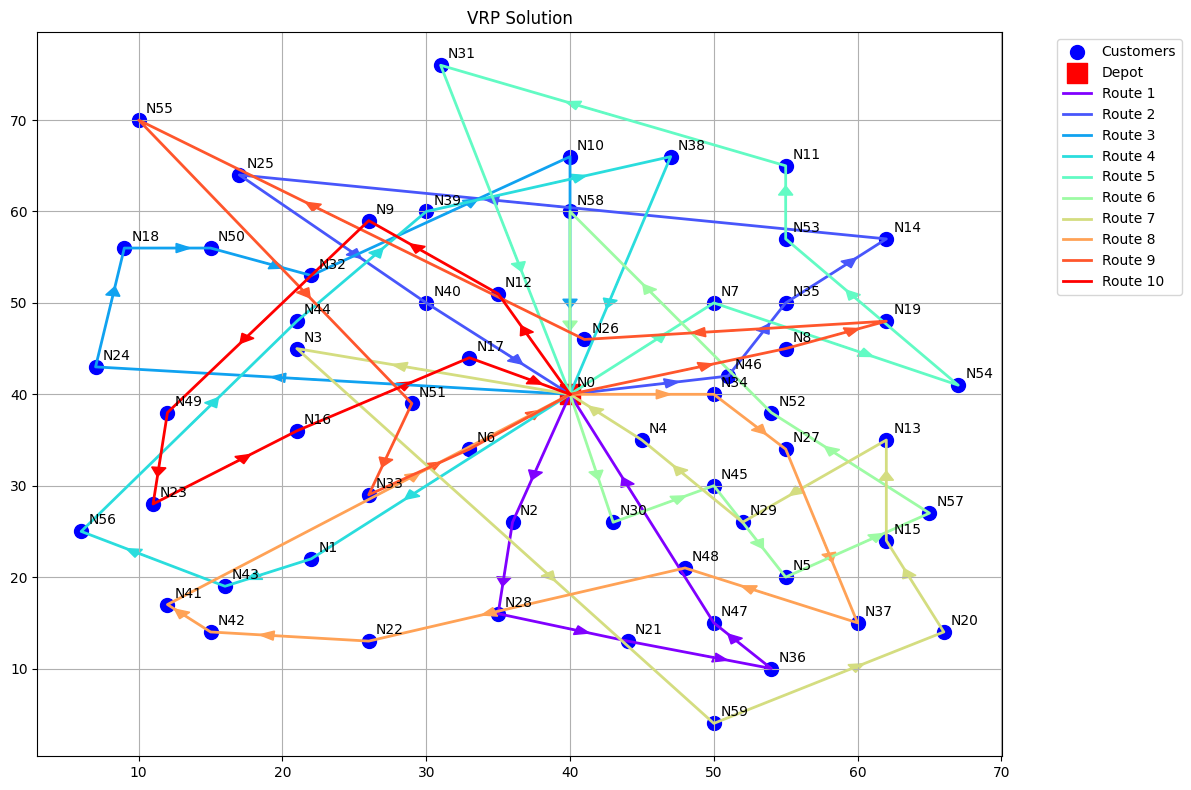


Best solution routes:
Route 1: [0, 2, 28, 21, 36, 47, 0] (Distance: 77.87)
Route 2: [0, 46, 35, 14, 25, 40, 0] (Distance: 108.81)
Route 3: [0, 24, 18, 50, 32, 10, 0] (Distance: 108.11)
Route 4: [0, 1, 43, 56, 44, 39, 38, 0] (Distance: 131.24)
Route 5: [0, 7, 54, 53, 11, 31, 0] (Distance: 124.89)
Route 6: [0, 30, 45, 5, 57, 52, 58, 0] (Distance: 107.40)
Route 7: [0, 3, 59, 20, 15, 13, 29, 4, 0] (Distance: 142.43)
Route 8: [0, 34, 27, 37, 48, 22, 42, 41, 0] (Distance: 125.81)
Route 9: [0, 8, 19, 26, 55, 51, 33, 6, 0] (Distance: 148.35)
Route 10: [0, 12, 9, 49, 23, 16, 17, 0] (Distance: 94.70)
Total distance: 1169.60
Execution time: 21.55 seconds

Solving P-n060-k15.xml
Number of cities: 60
Number of vehicles: 15
Vehicle capacity: 80.0
Generation 0: Best Fitness = 0.0005, Avg Fitness = 0.0005
Generation 1: Best Fitness = 0.0006, Avg Fitness = 0.0005
Generation 2: Best Fitness = 0.0007, Avg Fitness = 0.0006
Generation 3: Best Fitness = 0.0007, Avg Fitness = 0.0006
Generation 4: Best Fitne

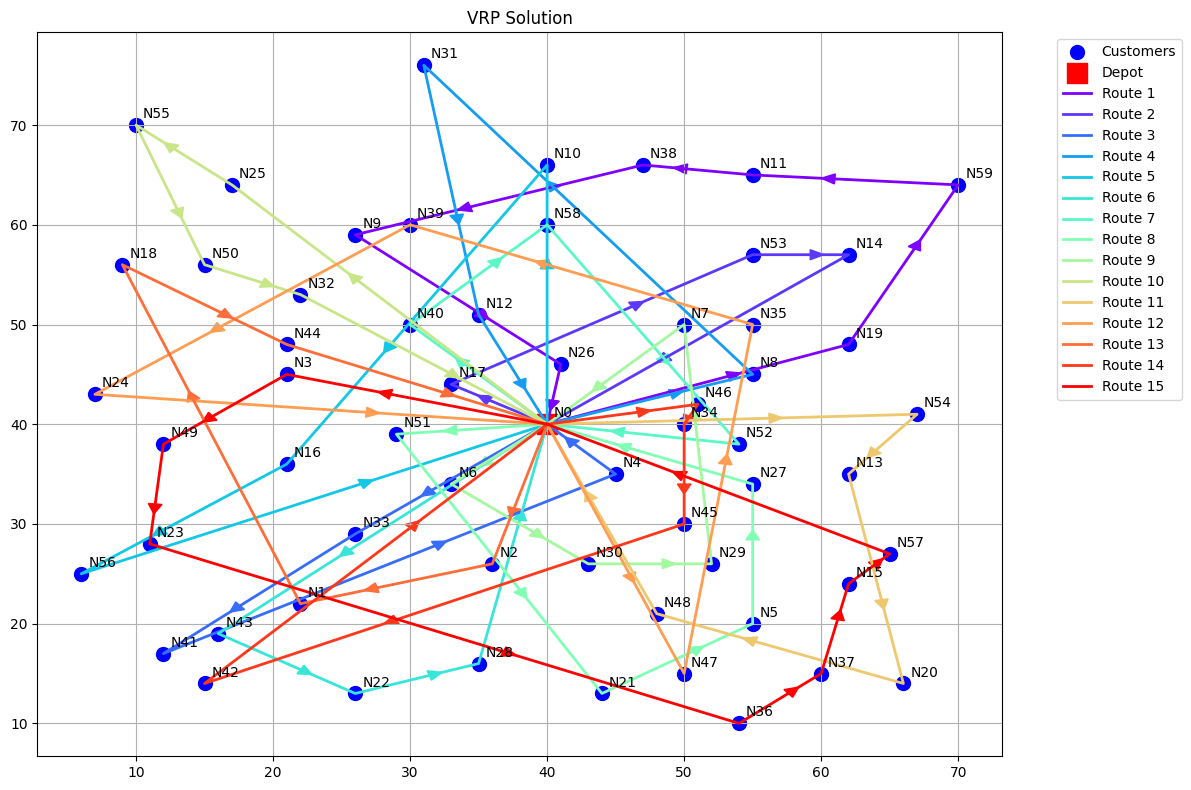


Best solution routes:
Route 1: [0, 19, 59, 11, 38, 9, 26, 0] (Distance: 112.46)
Route 2: [0, 17, 53, 14, 0] (Distance: 68.42)
Route 3: [0, 33, 41, 4, 0] (Distance: 80.90)
Route 4: [0, 8, 31, 12, 0] (Distance: 92.42)
Route 5: [0, 10, 16, 56, 0] (Distance: 117.27)
Route 6: [0, 43, 22, 28, 0] (Distance: 77.55)
Route 7: [0, 40, 58, 52, 0] (Distance: 68.50)
Route 8: [0, 51, 21, 5, 27, 0] (Distance: 84.26)
Route 9: [0, 6, 30, 29, 7, 0] (Distance: 69.25)
Route 10: [0, 25, 55, 50, 32, 0] (Distance: 87.15)
Route 11: [0, 54, 13, 20, 48, 0] (Distance: 96.14)
Route 12: [0, 47, 35, 39, 24, 0] (Distance: 150.94)
Route 13: [0, 2, 1, 18, 44, 0] (Distance: 100.56)
Route 14: [0, 46, 34, 45, 42, 0] (Distance: 97.97)
Route 15: [0, 3, 49, 23, 36, 37, 15, 57, 0] (Distance: 137.16)
Total distance: 1440.96
Execution time: 21.82 seconds

Solving P-n065-k10.xml
Number of cities: 65
Number of vehicles: 10
Vehicle capacity: 130.0
Generation 0: Best Fitness = 0.0006, Avg Fitness = 0.0005
Generation 1: Best Fitnes

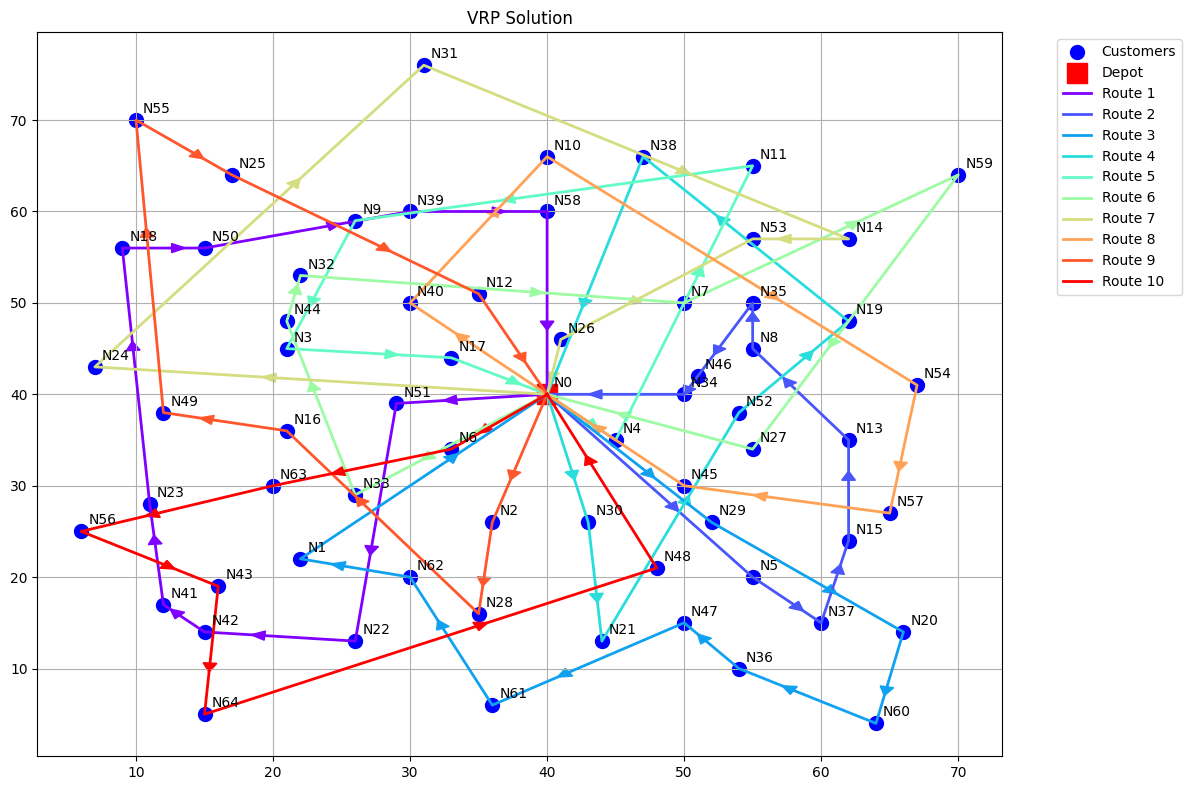


Best solution routes:
Route 1: [0, 51, 22, 42, 41, 23, 18, 50, 39, 58, 0] (Distance: 143.15)
Route 2: [0, 5, 37, 15, 13, 8, 35, 46, 34, 0] (Distance: 90.68)
Route 3: [0, 29, 20, 60, 36, 47, 61, 62, 1, 0] (Distance: 130.72)
Route 4: [0, 30, 21, 52, 19, 38, 0] (Distance: 117.44)
Route 5: [0, 4, 11, 9, 3, 17, 0] (Distance: 103.28)
Route 6: [0, 33, 44, 32, 7, 59, 27, 0] (Distance: 144.82)
Route 7: [0, 24, 31, 14, 53, 26, 0] (Distance: 141.19)
Route 8: [0, 40, 10, 54, 57, 45, 0] (Distance: 113.39)
Route 9: [0, 2, 28, 16, 49, 55, 25, 12, 0] (Distance: 133.81)
Route 10: [0, 6, 63, 56, 43, 64, 48, 0] (Distance: 120.67)
Total distance: 1239.15
Execution time: 51.16 seconds

Solving P-n070-k10.xml
Number of cities: 70
Number of vehicles: 10
Vehicle capacity: 135.0
Generation 0: Best Fitness = 0.0005, Avg Fitness = 0.0004
Generation 1: Best Fitness = 0.0007, Avg Fitness = 0.0005
Generation 2: Best Fitness = 0.0007, Avg Fitness = 0.0006
Generation 3: Best Fitness = 0.0007, Avg Fitness = 0.0006
Ge

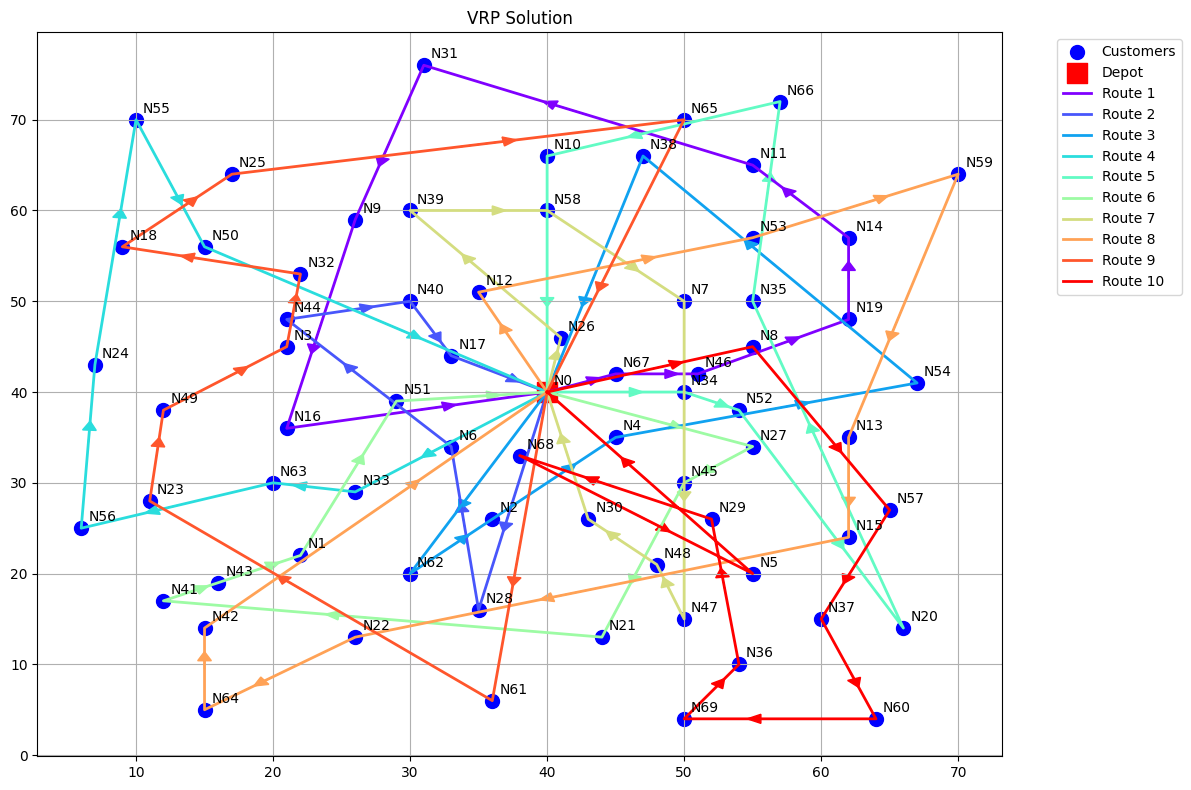


Best solution routes:
Route 1: [0, 67, 46, 19, 14, 11, 31, 9, 16, 0] (Distance: 130.62)
Route 2: [0, 28, 6, 44, 40, 17, 0] (Distance: 85.06)
Route 3: [0, 62, 2, 4, 54, 38, 0] (Distance: 125.32)
Route 4: [0, 33, 63, 56, 24, 55, 50, 0] (Distance: 128.49)
Route 5: [0, 34, 52, 20, 35, 66, 10, 0] (Distance: 145.07)
Route 6: [0, 27, 45, 21, 41, 43, 1, 51, 0] (Distance: 113.45)
Route 7: [0, 26, 39, 58, 7, 47, 48, 30, 0] (Distance: 110.74)
Route 8: [0, 12, 53, 59, 13, 15, 22, 64, 42, 0] (Distance: 186.91)
Route 9: [0, 61, 23, 49, 3, 32, 18, 25, 65, 0] (Distance: 186.87)
Route 10: [0, 8, 57, 37, 60, 69, 36, 29, 68, 5, 0] (Distance: 160.50)
Total distance: 1373.02
Execution time: 48.56 seconds

Solving P-n076-k04.xml
Number of cities: 76
Number of vehicles: 4
Vehicle capacity: 350.0
Generation 0: Best Fitness = 0.0006, Avg Fitness = 0.0005
Generation 1: Best Fitness = 0.0011, Avg Fitness = 0.0009
Generation 2: Best Fitness = 0.0012, Avg Fitness = 0.0010
Generation 3: Best Fitness = 0.0012, Avg 

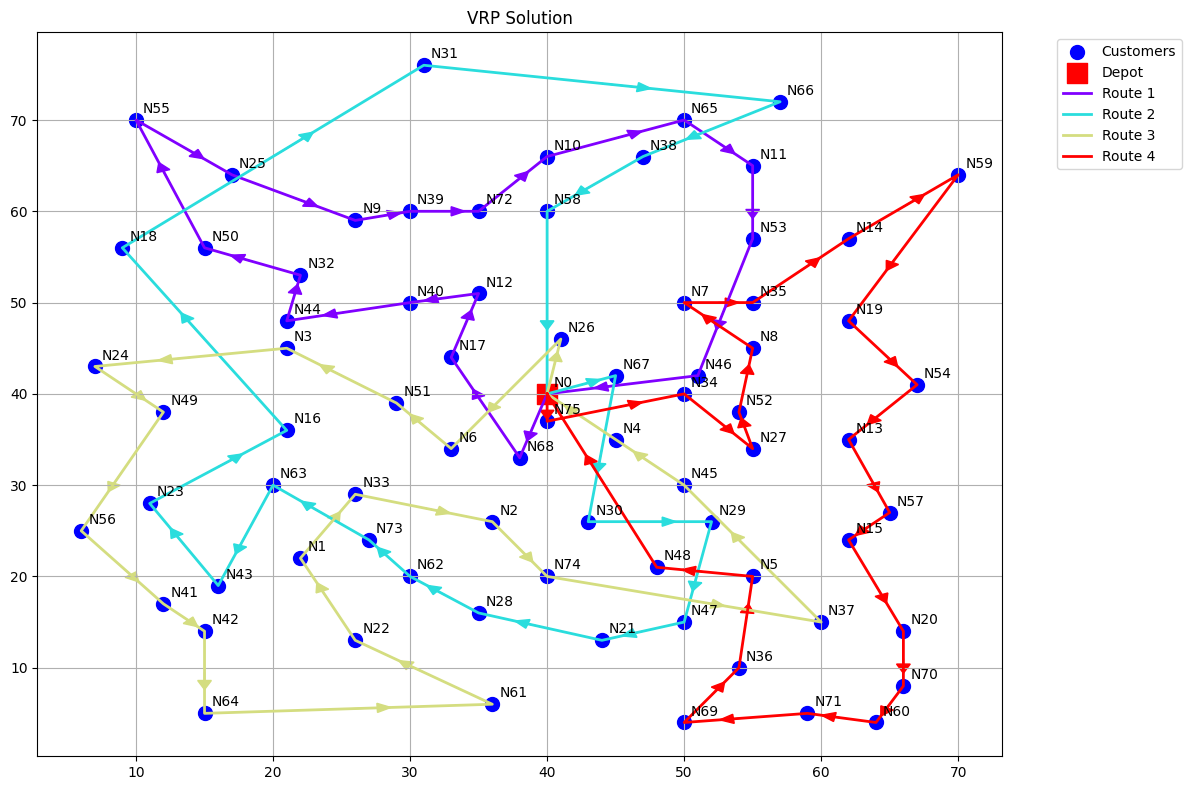


Best solution routes:
Route 1: [0, 68, 17, 12, 40, 44, 32, 50, 55, 25, 9, 39, 72, 10, 65, 11, 53, 46, 0] (Distance: 157.54)
Route 2: [0, 67, 30, 29, 47, 21, 28, 62, 73, 63, 43, 23, 16, 18, 31, 66, 38, 58, 0] (Distance: 233.17)
Route 3: [0, 26, 6, 51, 3, 24, 49, 56, 41, 42, 64, 61, 22, 1, 33, 2, 74, 37, 45, 4, 0] (Distance: 217.26)
Route 4: [0, 75, 34, 27, 52, 8, 7, 35, 14, 59, 19, 54, 13, 57, 15, 20, 70, 60, 71, 69, 36, 5, 48, 0] (Distance: 192.48)
Total distance: 800.45
Execution time: 150.09 seconds

Solving P-n076-k05.xml
Number of cities: 76
Number of vehicles: 5
Vehicle capacity: 280.0
Generation 0: Best Fitness = 0.0006, Avg Fitness = 0.0005
Generation 1: Best Fitness = 0.0009, Avg Fitness = 0.0008
Generation 2: Best Fitness = 0.0010, Avg Fitness = 0.0009
Generation 3: Best Fitness = 0.0011, Avg Fitness = 0.0009
Generation 4: Best Fitness = 0.0011, Avg Fitness = 0.0009
Generation 5: Best Fitness = 0.0006, Avg Fitness = 0.0005
Generation 6: Best Fitness = 0.0010, Avg Fitness = 0.

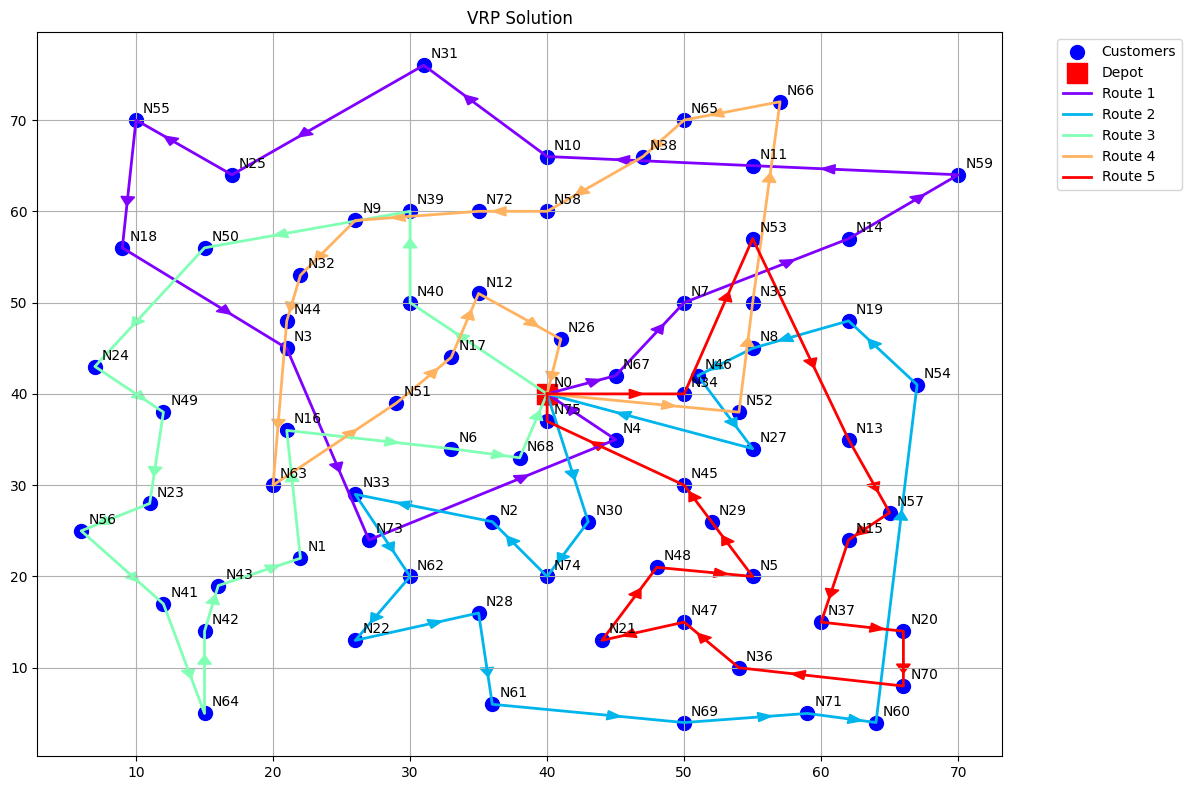


Best solution routes:
Route 1: [0, 67, 7, 14, 59, 11, 10, 31, 25, 55, 18, 3, 73, 4, 0] (Distance: 190.84)
Route 2: [0, 30, 74, 2, 33, 62, 22, 28, 61, 69, 71, 60, 54, 19, 8, 46, 27, 0] (Distance: 187.86)
Route 3: [0, 40, 39, 50, 24, 49, 23, 56, 41, 64, 42, 43, 1, 16, 6, 68, 0] (Distance: 159.64)
Route 4: [0, 52, 35, 66, 65, 38, 58, 72, 9, 32, 44, 63, 51, 17, 12, 26, 0] (Distance: 154.47)
Route 5: [0, 34, 53, 13, 57, 15, 37, 20, 70, 36, 47, 21, 48, 5, 29, 45, 75, 0] (Distance: 152.19)
Total distance: 845.00
Execution time: 207.81 seconds

Solving P-n101-k04.xml
Number of cities: 101
Number of vehicles: 4
Vehicle capacity: 400.0
Generation 0: Best Fitness = 0.0006, Avg Fitness = 0.0005
Generation 1: Best Fitness = 0.0009, Avg Fitness = 0.0008
Generation 2: Best Fitness = 0.0010, Avg Fitness = 0.0009
Generation 3: Best Fitness = 0.0010, Avg Fitness = 0.0009
Generation 4: Best Fitness = 0.0010, Avg Fitness = 0.0009
Generation 5: Best Fitness = 0.0006, Avg Fitness = 0.0005
Generation 6: Bes

In [ ]:
def parse_xml_file(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()

    # Parse nodes
    nodes = []
    for node in root.findall('.//node'):
        node_id = int(node.get('id'))
        node_type = int(node.get('type'))
        cx = float(node.find('cx').text)
        cy = float(node.find('cy').text)
        nodes.append((node_id, node_type, cx, cy))

    # Parse vehicle capacity
    capacity = float(root.find('.//vehicle_profile/capacity').text)

    # Extract number of vehicles from filename (e.g., k05 means 5 vehicles)
    filename = os.path.basename(file_path)
    match = re.search(r'-k(\d+)', filename)
    if match:
        num_vehicles = int(match.group(1))  # Convert k05 to 5
    else:
        # Fallback to counting vehicle profiles if filename pattern doesn't match
        num_vehicles = len(root.findall('.//vehicle_profile'))

    # Parse demands
    demands = [0]  # Depot has no demand
    for request in root.findall('.//request'):
        demands.append(float(request.find('quantity').text))

    return nodes, capacity, num_vehicles, demands

def create_distance_matrix(nodes):
    coordinates = np.array([(x, y) for _, _, x, y in nodes])
    return squareform(pdist(coordinates))

def solve_vrp(file_path):
    # Parse XML data
    nodes, capacity, num_vehicles, demands = parse_xml_file(file_path)
    num_cities = len(nodes)

    # Create distance matrix
    global dist_matrix
    dist_matrix = create_distance_matrix(nodes)

    # Algorithm parameters
    pop_size = 500
    generations = 20
    early_stopping_generations = 5

    print(f"\nSolving {os.path.basename(file_path)}")
    print(f"Number of cities: {num_cities}")
    print(f"Number of vehicles: {num_vehicles}")
    print(f"Vehicle capacity: {capacity}")

    # Start timer
    start_time = time.time()

    # Run evolution and get best solution
    best_individual = evolve_population(
        pop_size=pop_size,
        generations=generations,
        early_stopping_generations=early_stopping_generations,
        num_cities=num_cities,
        num_vehicles=num_vehicles,
        capacity=capacity,
        demands=demands
    )

    # Get the best routes
    best_routes = best_individual.get_routes()

    # Plot the solution
    plot_solution(nodes, best_routes)

    # Print route details
    print("\nBest solution routes:")
    total_distance = 0
    for i, route in enumerate(best_routes, 1):
        route_distance = calculate_route_distance(route)
        total_distance += route_distance
        print(f"Route {i}: {[0] + list(route) + [0]} (Distance: {route_distance:.2f})")
    print(f"Total distance: {total_distance:.2f}")

    # Print execution time
    execution_time = time.time() - start_time
    print(f"Execution time: {execution_time:.2f} seconds")

def calculate_route_distance(route):
    distance = dist_matrix[0, route[0]]  # Depot to first city
    for i in range(len(route)-1):
        distance += dist_matrix[route[i], route[i+1]]
    distance += dist_matrix[route[-1], 0]  # Last city to depot
    return distance

def plot_solution(nodes, routes):
    plt.figure(figsize=(12, 8))

    # Plot nodes
    coordinates = np.array([(x, y) for _, _, x, y in nodes])
    plt.scatter(coordinates[1:, 0], coordinates[1:, 1], c='blue', s=100, label='Customers')
    plt.scatter(coordinates[0, 0], coordinates[0, 1], c='red', marker='s', s=200, label='Depot')

    # Plot routes with different colors
    colors = plt.cm.rainbow(np.linspace(0, 1, len(routes)))
    for i, (route, color) in enumerate(zip(routes, colors)):
        route_coords = coordinates[[0] + list(route) + [0]]
        plt.plot(route_coords[:, 0], route_coords[:, 1], c=color, linewidth=2, label=f'Route {i+1}')

        # Add arrows to show direction
        for j in range(len(route_coords)-1):
            mid_x = (route_coords[j][0] + route_coords[j+1][0]) / 2
            mid_y = (route_coords[j][1] + route_coords[j+1][1]) / 2
            plt.arrow(mid_x, mid_y,
                     (route_coords[j+1][0] - route_coords[j][0])/10,
                     (route_coords[j+1][1] - route_coords[j][1])/10,
                     head_width=1, head_length=1, fc=color, ec=color)

    # Add node labels
    for i, coord in enumerate(coordinates):
        plt.annotate(f'N{i}', (coord[0], coord[1]), xytext=(5, 5),
                    textcoords='offset points')

    plt.title('VRP Solution')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def main():
    # Get all XML files
    xml_files = glob.glob('P-n*.xml')

    for file_path in sorted(xml_files):
        solve_vrp(file_path)

if __name__ == "__main__":
    main()